In [ ]:
!pip install adjustText
!pip install catboost
!pip install shap
!pip install eli5
import pandas as pd
import re
import warnings
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import shap
import eli5
from eli5.sklearn import PermutationImportance  
from matplotlib.ticker import FuncFormatter
from adjustText import adjust_text
from textwrap import wrap
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV,KFold,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from catboost import Pool, cv, CatBoostClassifier
from sklearn.metrics import  classification_report, log_loss, roc_auc_score
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
games = pd.read_csv("/content/drive/MyDrive/datasets/DATASET NBA/data complémentaires/KAGGLE Dataset with all NBA games from 2004 season to dec 2020/games.csv")
details = pd.read_csv("/content/drive/MyDrive/datasets/DATASET NBA/data complémentaires/KAGGLE Dataset with all NBA games from 2004 season to dec 2020/games_details.csv")
teams = pd.read_csv("/content/drive/MyDrive/datasets/DATASET NBA/data complémentaires/KAGGLE Dataset with all NBA games from 2004 season to dec 2020/teams.csv")
players = pd.read_csv("/content/drive/MyDrive/datasets/DATASET NBA/data complémentaires/KAGGLE Dataset with all NBA games from 2004 season to dec 2020/players.csv")
ranking = pd.read_csv("/content/drive/MyDrive/datasets/DATASET NBA/data complémentaires/KAGGLE Dataset with all NBA games from 2004 season to dec 2020/ranking.csv")

In [ ]:
games.head(1)

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2021-05-26,42000102,Final,1610612755,1610612764,2020,1610612755,120.0,0.557,0.684,0.429,26.0,45.0,1610612764,95.0,0.402,0.633,0.091,22.0,40.0,1


In [ ]:
games['PTS_home'].dtype

dtype('float64')

In [ ]:
# games['PTS_home']=games[['PTS_home']].dropna().astype(int)  ### inneficace

In [ ]:
games = games.dropna(axis=0).astype({'PTS_home': np.int})
games = games.dropna(axis=0).astype({'PTS_away': np.int})

In [ ]:
# creation nouvelle colonne 'result'
games['result']=games['PTS_home'].astype(str)+":"+games['PTS_away'].astype(str)

In [ ]:
games.head(1)

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,result
0,2021-05-26,42000102,Final,1610612755,1610612764,2020,1610612755,120,0.557,0.684,0.429,26.0,45.0,1610612764,95,0.402,0.633,0.091,22.0,40.0,1,120:95


In [ ]:
# avant reformatage
games.describe()

,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
count,2.457800e+04,2.457800e+04,2.457800e+04,24578.000000,2.457800e+04,24578.000000,24578.000000,24578.000000,24578.000000,24578.000000,24578.000000,2.457800e+04,24578.000000,24578.000000,24578.00000,24578.000000,24578.000000,24578.000000,24578.000000
mean,2.169025e+07,1.610613e+09,1.610613e+09,2011.416592,1.610613e+09,102.766621,0.460256,0.759083,0.356084,22.649972,43.272764,1.610613e+09,99.907641,0.449023,0.75738,0.349443,21.296607,41.972821,0.591423
std,5.456096e+06,8.643714e+00,8.658480e+00,5.128362,8.643714e+00,13.112642,0.056706,0.100530,0.113140,5.169164,6.609140,8.658480e+00,13.247136,0.055554,0.10330,0.111319,5.126141,6.508188,0.491581
min,1.030000e+07,1.610613e+09,1.610613e+09,2003.000000,1.610613e+09,36.000000,0.250000,0.143000,0.000000,6.000000,15.000000,1.610613e+09,33.000000,0.244000,0.14300,0.000000,4.000000,19.000000,0.000000
25%,2.060095e+07,1.610613e+09,1.610613e+09,2007.000000,1.610613e+09,94.000000,0.421000,0.696000,0.286000,19.000000,39.000000,1.610613e+09,91.000000,0.411000,0.69200,0.278000,18.000000,38.000000,0.000000
50%,2.110095e+07,1.610613e+09,1.610613e+09,2012.000000,1.610613e+09,102.000000,0.459000,0.765000,0.357000,22.000000,43.000000,1.610613e+09,99.000000,0.448000,0.76200,0.350000,21.000000,42.000000,1.000000
75%,2.160118e+07,1.610613e+09,1.610613e+09,2016.000000,1.610613e+09,111.000000,0.500000,0.828000,0.429000,26.000000,48.000000,1.610613e+09,109.000000,0.487000,0.82800,0.421000,25.000000,46.000000,1.000000
max,5.200021e+07,1.610613e+09,1.610613e+09,2020.000000,1.610613e+09,168.000000,0.684000,1.000000,1.000000,50.000000,72.000000,1.610613e+09,168.000000,0.674000,1.00000,1.000000,46.000000,81.000000,1.000000


In [ ]:
# Reformatage Player NAME
details['PLAYER_NAME_SHORT'] = details['PLAYER_NAME'].str.replace('^(.).*\s(.*)', '\\1.\\2')   #     .* <=> followed by 0 or more (any) characters       ^<=> starts with 
# Reformatage Colonne  MIN
details[["MINS", "SECS"]] = details.MIN.str.extract(r"([^:]+):(.*)")
details.loc[(~details.MIN.str.contains(':', na = True)), 'SECS'] = details.MIN
details.MINS = pd.to_numeric(details.MINS)
details.SECS = pd.to_numeric(details.SECS)
details['PLAY_TIME'] = np.round(details.MINS.fillna(0) + details.SECS/60)

In [ ]:
# Apres reformatage
details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615626 entries, 0 to 615625
Data columns (total 32 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   GAME_ID            615626 non-null  int64  
 1   TEAM_ID            615626 non-null  int64  
 2   TEAM_ABBREVIATION  615626 non-null  object 
 3   TEAM_CITY          615626 non-null  object 
 4   PLAYER_ID          615626 non-null  int64  
 5   PLAYER_NAME        615626 non-null  object 
 6   START_POSITION     235795 non-null  object 
 7   COMMENT            100048 non-null  object 
 8   MIN                515577 non-null  object 
 9   FGM                515577 non-null  float64
 10  FGA                515577 non-null  float64
 11  FG_PCT             515577 non-null  float64
 12  FG3M               515577 non-null  float64
 13  FG3A               515577 non-null  float64
 14  FG3_PCT            515577 non-null  float64
 15  FTM                515577 non-null  float64
 16  FT

In [ ]:
# DONNEES DE BASE DE LA TABLE 'INITIALE' GAME
games = games.loc[~games[['GAME_ID', 'GAME_DATE_EST']].duplicated()] #Leaving one entry per game
games['GAME_DATE_EST'] = pd.to_datetime(games.GAME_DATE_EST)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# après reformatage
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24523 entries, 0 to 24676
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   GAME_DATE_EST     24523 non-null  datetime64[ns]
 1   GAME_ID           24523 non-null  int64         
 2   GAME_STATUS_TEXT  24523 non-null  object        
 3   HOME_TEAM_ID      24523 non-null  int64         
 4   VISITOR_TEAM_ID   24523 non-null  int64         
 5   SEASON            24523 non-null  int64         
 6   TEAM_ID_home      24523 non-null  int64         
 7   PTS_home          24523 non-null  int64         
 8   FG_PCT_home       24523 non-null  float64       
 9   FT_PCT_home       24523 non-null  float64       
 10  FG3_PCT_home      24523 non-null  float64       
 11  AST_home          24523 non-null  float64       
 12  REB_home          24523 non-null  float64       
 13  TEAM_ID_away      24523 non-null  int64         
 14  PTS_away          2452

In [ ]:
def get_season(date): ###
    '''
    Returns the season based on the month and year of a date
    '''
    date = pd.to_datetime(date, format='%Y-%m-%d')
    if (date.month >= 10):
        season = date.year
    else:
        season = date.year - 1
    return season

def get_season_data(season):
    ''' 
    Aggregates the details data into yearly figures
    Returns the aggregated data and the standardised aggregated data    
    '''
    # Création nouvelles tables à partir de la table details
    temp = details.loc[details.GAME_ID.isin(games.loc[games.SEASON == season, 'GAME_ID'])]
    temp = temp.loc[~temp['PLAY_TIME'].isnull()]
    agg_df = temp.groupby(['PLAYER_ID', 'PLAYER_NAME', 'PLAYER_NAME_SHORT'])[['FGA', 'FGM', 'FG3A', 'FG3M', 'FTA', 'FTM', 'OREB', 'DREB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PLAY_TIME']].sum().reset_index()
    agg_df = agg_df.loc[agg_df['PLAY_TIME'] >= 1200].reset_index(drop = True) #### choix arbitraire de 1200min
    st_agg_df = StandardScaler().fit_transform(agg_df.drop(columns = ['PLAYER_ID', 'PLAYER_NAME', 'PLAY_TIME', 'PLAYER_NAME_SHORT']))
    return(agg_df, st_agg_df)

In [ ]:
# MACHINE LEARNING NON SUPERVISE -> PCA
pca = PCA(n_components = 3)
agg_df, st_agg_df = get_season_data(2020) ###
pcomp = pca.fit_transform(st_agg_df) # PCA sur données standardisées
df = pd.DataFrame(pca.components_, 
             index = ['PC 1', 'PC 2','PC 3'],
             columns = agg_df.drop(columns = ['PLAYER_ID', 'PLAYER_NAME', 'PLAY_TIME', 'PLAYER_NAME_SHORT']).columns).round(2)
styles = [dict(selector="caption", props=[("caption-side", "bottom")])]
df.style.set_table_styles(styles).set_properties(**{'font-size':'8pt'}).background_gradient('Greens').set_precision(2).set_caption('Breakdown of the principal components for the 2020 season')

,FGA,FGM,FG3A,FG3M,FTA,FTM,OREB,DREB,AST,STL,BLK,TO,PF
PC 1,0.39,0.39,0.19,0.18,0.36,0.37,0.05,0.23,0.31,0.20,0.02,0.38,0.15
PC 2,-0.10,0.01,-0.41,-0.41,0.11,0.05,0.50,0.35,-0.09,-0.04,0.42,0.03,0.28
PC 3,-0.14,-0.12,-0.42,-0.45,0.14,0.13,-0.12,-0.22,0.43,0.29,-0.29,0.20,-0.30


In [ ]:
pca = PCA(n_components = 2)
agg_df, st_agg_df = get_season_data(2020)
pcomp = pca.fit_transform(st_agg_df)
df = pd.DataFrame(pca.components_, 
             index = ['PC 1', 'PC 2'],
             columns = agg_df.drop(columns = ['PLAYER_ID', 'PLAYER_NAME', 'PLAY_TIME', 'PLAYER_NAME_SHORT']).columns).round(2)
styles = [dict(selector="caption", props=[("caption-side", "bottom")])]
df.style.set_table_styles(styles).set_properties(**{'font-size':'8pt'}).background_gradient('Greens').set_precision(2).set_caption('Breakdown of the principal components for the 2020 season')

,FGA,FGM,FG3A,FG3M,FTA,FTM,OREB,DREB,AST,STL,BLK,TO,PF
PC 1,0.39,0.39,0.19,0.18,0.36,0.37,0.05,0.23,0.31,0.20,0.02,0.38,0.15
PC 2,-0.10,0.01,-0.41,-0.41,0.11,0.05,0.50,0.35,-0.09,-0.04,0.42,0.03,0.28


In [ ]:
def pca_plots(season, ax = None):
    '''
    Performs PCA on season data
    Calculates the top players based on the 2 PCs
    Creates a scatter plot for visualising the season data
    '''    
    #pca = PCA(n_components = 3)
    pca = PCA(n_components = 2)
    agg_df, st_agg_df = get_season_data(season)
    pcomp = pca.fit_transform(st_agg_df)    
    overall = pcomp.sum(axis = 1)
    top_overall = np.argpartition(overall, -4)[-4:]
    top_pc1 = np.argpartition(pcomp[:,0], -4)[-4:]
    top_pc2 = np.argpartition(pcomp[:,1], -4)[-4:]
    # top_pc3 = np.argpartition(pcomp[:,2], -4)[-4:]
    # top_pc = list(set(list(top_pc1) + list(top_pc2) + list(top_pc3) + list(top_overall)))
    top_pc = list(set(list(top_pc1) + list(top_pc2) + list(top_overall)))
    ##alphas = np.zeros(pcomp.shape[0]) + 0.3
    ##alphas[top_pc] = 1    
    # ax.scatter(pcomp[:, 0], pcomp[:, 1], pcomp[:, 2], alpha = alphas)
    ax.scatter(pcomp[:, 0], pcomp[:, 1])##, alpha = alphas)
    ax.axhline(y = 0, color ='green', linestyle='--', lw=1)
    ax.axvline(x = 0, color ='green', linestyle='--', lw=1)
    #texts = [ax.text(x=pcomp[i, 0],y=pcomp[i, 1], z=pcomp[i, 2],s=agg_df.PLAYER_NAME_SHORT[i]) for i in top_pc]
    texts = [ax.text(x=pcomp[i, 0],y=pcomp[i, 1],s=agg_df.PLAYER_NAME_SHORT[i]) for i in top_pc]
    adjust_text(texts, ax = ax, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
    _ = ax.set_title(str(season))

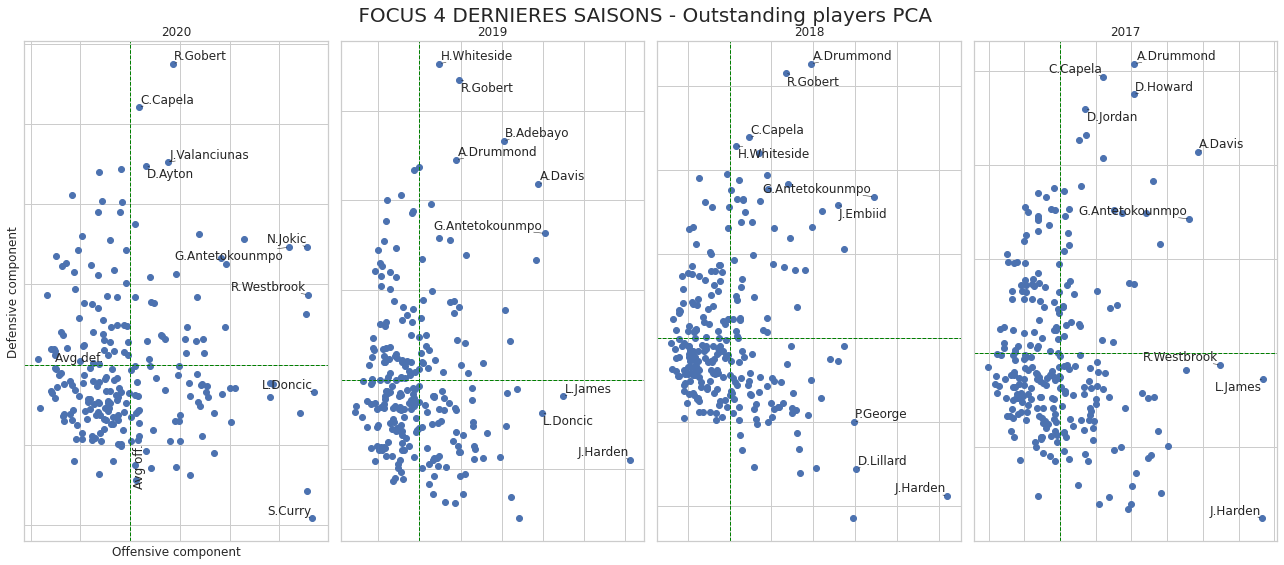

In [ ]:
# FOCUS SUR LES 4 DERNIERES SAISONS
fig,axes = plt.subplots(1, 4, figsize=(18,8))
for i,season in enumerate(range(games.SEASON.max(), games.SEASON.min()+13, -1)):
    pca_plots(season, ax = axes.ravel()[i])    
    axes.ravel()[i].tick_params(bottom=False, left=False, labelbottom = False, labelleft = False)
    if (i % 5 == 0 ):
        axes.ravel()[i].set_xlabel('Offensive component')
        axes.ravel()[i].set_ylabel('Defensive component')
        axes.ravel()[i].text(x = 0.1, y = -3, s = 'Avg off.',rotation=90)
        axes.ravel()[i].text(x = -3, y = 0.1, s = 'Avg def.')
fig.suptitle(' FOCUS 4 DERNIERES SAISONS - Outstanding players PCA', fontsize = 20)
fig.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()

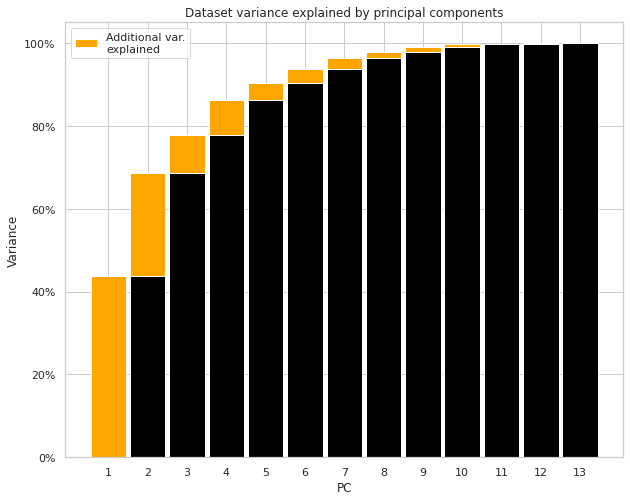

In [ ]:
# explication de la variance vs nb de composantes principales
pca_all = PCA()
pca_all.fit(st_agg_df)
cum_var = np.cumsum(pca_all.explained_variance_ratio_)
cum_var = np.insert(cum_var, 0, 0)
cum_var = cum_var[:-1]

comp = [str(x + 1) for x in range(pca_all.n_components_)]
fig, ax = plt.subplots(figsize=(10,8))
ax.bar(comp, cum_var, align='center', width=0.9, color='black', label='_nolegend_')
ax.bar(comp, pca_all.explained_variance_ratio_, bottom=cum_var, align='center', width=0.9, color='orange', label= '\n'.join(wrap('Additional var. explained', 20)))
ax.set_ylabel('Variance')
ax.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
ax.set_xlabel('PC')
ax.set_title('Dataset variance explained by principal components')
ax.legend()
plt.show()

## **Preparation of modelling**

In [ ]:
# PREPARATION DES TABLES

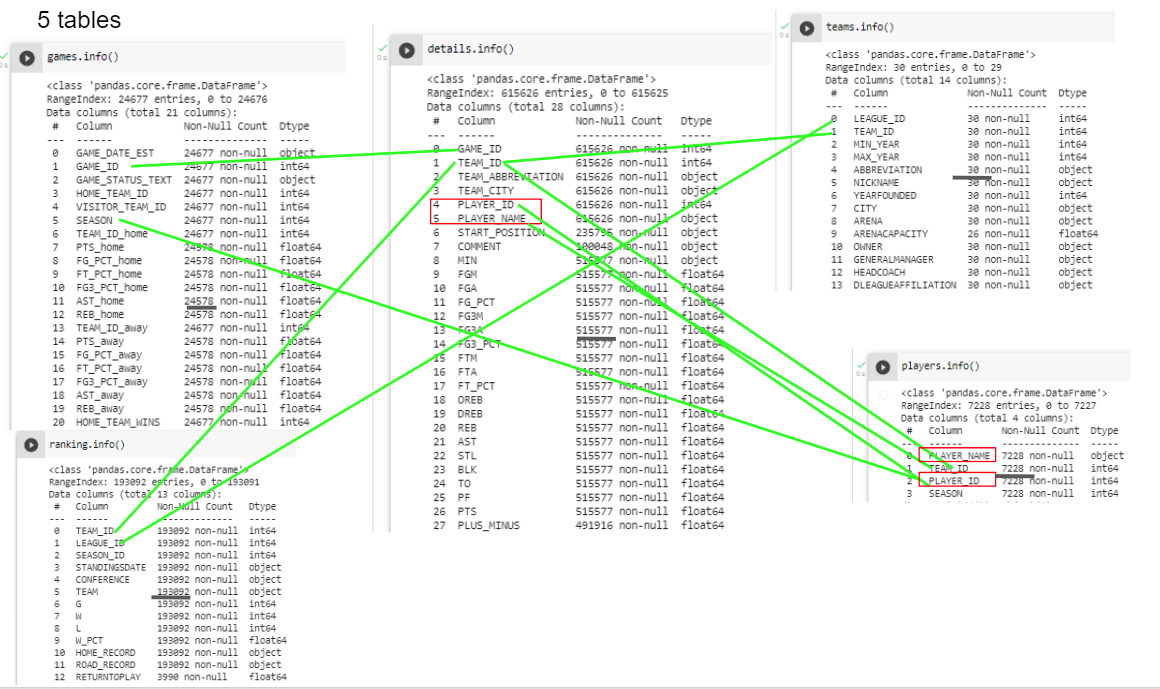

In [ ]:
# TABLE RANKING
ranking['STANDINGSDATE'] = pd.to_datetime(ranking['STANDINGSDATE'])
ranking.sort_values('STANDINGSDATE', inplace = True)
ranking = ranking.loc[ranking.SEASON_ID // 10000 == 2]
ranking['SEASON_ID'] = ranking['SEASON_ID'] % 10000
ranking['MAX_S_GAMES'] = ranking.groupby('SEASON_ID').G.transform(max)
ranking.head(1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,TEAM_ID,LEAGUE_ID,SEASON_ID,STANDINGSDATE,CONFERENCE,TEAM,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD,RETURNTOPLAY,MAX_S_GAMES
164300,1610612752,0,2002,2003-10-01,East,New York,82,37,45,0.451,24-17,13-28,NaN,82


In [ ]:
#CHECK
ranking.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181259 entries, 164300 to 0
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   TEAM_ID        181259 non-null  int64         
 1   LEAGUE_ID      181259 non-null  int64         
 2   SEASON_ID      181259 non-null  int64         
 3   STANDINGSDATE  181259 non-null  datetime64[ns]
 4   CONFERENCE     181259 non-null  object        
 5   TEAM           181259 non-null  object        
 6   G              181259 non-null  int64         
 7   W              181259 non-null  int64         
 8   L              181259 non-null  int64         
 9   W_PCT          181259 non-null  float64       
 10  HOME_RECORD    181259 non-null  object        
 11  ROAD_RECORD    181259 non-null  object        
 12  RETURNTOPLAY   3990 non-null    float64       
 13  MAX_S_GAMES    181259 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(7), object(4

In [ ]:
## A PARTIR DE LA TABLE RANKING
# Création d'un df avec début et fin de saison pour exclure les matchs de pré-saison et éliminatoires
start_dates = ranking.loc[ranking.SEASON_ID > 2002].groupby('SEASON_ID')['STANDINGSDATE'].min().to_frame('FIRST_GAME').reset_index()     #ranking.SEASON_ID > 2002     ######
t = ranking.loc[(ranking['G'] == ranking['MAX_S_GAMES'])].groupby(['SEASON_ID', 'STANDINGSDATE'])['TEAM_ID'].nunique().to_frame('TEAMS').reset_index()


In [ ]:
#CHECK
t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2961 entries, 0 to 2960
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   SEASON_ID      2961 non-null   int64         
 1   STANDINGSDATE  2961 non-null   datetime64[ns]
 2   TEAMS          2961 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 69.5 KB


In [ ]:
playoff_dates = t.loc[(t.TEAMS == 30) | ((t.TEAMS == 28) & (t.SEASON_ID == 2012)) | ((t.TEAMS == 29) & (t.SEASON_ID == 2003))].groupby('SEASON_ID')['STANDINGSDATE'].min().to_frame('LAST_GAME').reset_index()
#playoff_dates = t.loc[(t.TEAMS == 30)].groupby('SEASON_ID')['STANDINGSDATE'].min().to_frame('LAST_GAME').reset_index()                                                  ######
dates = start_dates.merge(playoff_dates, how = 'left')
dates.loc[dates.SEASON_ID == 2019, 'LAST_GAME'] = pd.to_datetime('2020-03-12') #Manually adding the end of regular season  #!!!!!

# CHECK
dates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 0 to 17
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   SEASON_ID   18 non-null     int64         
 1   FIRST_GAME  18 non-null     datetime64[ns]
 2   LAST_GAME   18 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(1)
memory usage: 576.0 bytes


In [ ]:
# TABLE DETAILS - selection des données de la saison régulière
# FUSION 1 
details = details.merge(games[['GAME_ID', 'GAME_DATE_EST', 'SEASON']], how = 'left')
# FUSION 2
details = details.merge(dates, left_on = 'SEASON', right_on = 'SEASON_ID', how = 'left')
details = details.loc[(details.LAST_GAME.isnull()) | ((details.GAME_DATE_EST <= details.LAST_GAME) & (details.GAME_DATE_EST > details.FIRST_GAME))]
#details = details.loc[(details.GAME_DATE_EST <= details.LAST_GAME) & (details.GAME_DATE_EST > details.FIRST_GAME)]

# CHECK
details.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 531195 entries, 645 to 612892
Data columns (total 37 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   GAME_ID            531195 non-null  int64         
 1   TEAM_ID            531195 non-null  int64         
 2   TEAM_ABBREVIATION  531195 non-null  object        
 3   TEAM_CITY          531195 non-null  object        
 4   PLAYER_ID          531195 non-null  int64         
 5   PLAYER_NAME        531195 non-null  object        
 6   START_POSITION     214096 non-null  object        
 7   COMMENT            87674 non-null   object        
 8   MIN                443521 non-null  object        
 9   FGM                443521 non-null  float64       
 10  FGA                443521 non-null  float64       
 11  FG_PCT             443521 non-null  float64       
 12  FG3M               443521 non-null  float64       
 13  FG3A               443521 non-null  float6

In [ ]:
# TABLE GAMES (DONNEES DE BASE DE LA TABLE INITIALE)
# FUSION 1
games = games.merge(dates, left_on = 'SEASON', right_on = 'SEASON_ID', how = 'inner')
# selection des données de la saison régulière 
games = games.loc[games.LAST_GAME.isnull() | ((games.GAME_DATE_EST <= games.LAST_GAME) & (games.GAME_DATE_EST > games.FIRST_GAME))]
games.drop(columns = ['SEASON_ID', 'FIRST_GAME', 'LAST_GAME'], inplace=True)

# CHECK
games.info(1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21396 entries, 22 to 24412
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   GAME_DATE_EST     21396 non-null  datetime64[ns]
 1   GAME_ID           21396 non-null  int64         
 2   GAME_STATUS_TEXT  21396 non-null  object        
 3   HOME_TEAM_ID      21396 non-null  int64         
 4   VISITOR_TEAM_ID   21396 non-null  int64         
 5   SEASON            21396 non-null  int64         
 6   TEAM_ID_home      21396 non-null  int64         
 7   PTS_home          21396 non-null  int64         
 8   FG_PCT_home       21396 non-null  float64       
 9   FT_PCT_home       21396 non-null  float64       
 10  FG3_PCT_home      21396 non-null  float64       
 11  AST_home          21396 non-null  float64       
 12  REB_home          21396 non-null  float64       
 13  TEAM_ID_away      21396 non-null  int64         
 14  PTS_away          213

In [ ]:
## A PARTIR DE LA TABLE RANKING -> Création d'un nouveau df RANKING_SHORT avec la saison régulière uniquement et des valeurs pouvant être utilisées pour la modélisation
ranking_short = ranking[['TEAM_ID', 'SEASON_ID', 'STANDINGSDATE', 'CONFERENCE', 'TEAM', 'G', 'W', 'L', 'HOME_RECORD', 'ROAD_RECORD']].merge(dates)
ranking_short = ranking_short.loc[(ranking_short.STANDINGSDATE >= ranking_short.FIRST_GAME) & (ranking_short.STANDINGSDATE <= ranking_short.LAST_GAME)]
ranking_short = ranking_short.loc[ranking_short.G > 0]

In [ ]:
# CHECK
ranking_short.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88653 entries, 9 to 180842
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   TEAM_ID        88653 non-null  int64         
 1   SEASON_ID      88653 non-null  int64         
 2   STANDINGSDATE  88653 non-null  datetime64[ns]
 3   CONFERENCE     88653 non-null  object        
 4   TEAM           88653 non-null  object        
 5   G              88653 non-null  int64         
 6   W              88653 non-null  int64         
 7   L              88653 non-null  int64         
 8   HOME_RECORD    88653 non-null  object        
 9   ROAD_RECORD    88653 non-null  object        
 10  FIRST_GAME     88653 non-null  datetime64[ns]
 11  LAST_GAME      88653 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(5), object(4)
memory usage: 8.8+ MB


In [ ]:
### encodage manuel ONE HOT
ranking_short[['HOME_W', 'HOME_L']] = ranking_short.HOME_RECORD.str.split('-', expand = True)
ranking_short[['AWAY_W', 'AWAY_L']] = ranking_short.ROAD_RECORD.str.split('-', expand = True)
ranking_short[['HOME_W', 'HOME_L', 'AWAY_W', 'AWAY_L']] = ranking_short[['HOME_W', 'HOME_L', 'AWAY_W', 'AWAY_L']].apply(pd.to_numeric) 
ranking_short.drop(columns = ['SEASON_ID', 'FIRST_GAME', 'LAST_GAME', 'HOME_RECORD', 'ROAD_RECORD'], inplace = True)
ranking_short.sort_values('STANDINGSDATE', inplace = True)
# CHECK
ranking_short.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88653 entries, 9 to 180842
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   TEAM_ID        88653 non-null  int64         
 1   STANDINGSDATE  88653 non-null  datetime64[ns]
 2   CONFERENCE     88653 non-null  object        
 3   TEAM           88653 non-null  object        
 4   G              88653 non-null  int64         
 5   W              88653 non-null  int64         
 6   L              88653 non-null  int64         
 7   HOME_W         88653 non-null  int64         
 8   HOME_L         88653 non-null  int64         
 9   AWAY_W         88653 non-null  int64         
 10  AWAY_L         88653 non-null  int64         
dtypes: datetime64[ns](1), int64(8), object(2)
memory usage: 8.1+ MB


In [ ]:
## A PARTIR DE LA TABLE GAMES -> Création d'un nouveau df GAMES_SHORT avec la saison régulière uniquement et des valeurs pouvant être utilisées pour la modélisation
games_short = pd.merge(games[['GAME_ID', 'GAME_DATE_EST', 'SEASON', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'HOME_TEAM_WINS','result']], dates, left_on = 'SEASON', right_on = 'SEASON_ID')
games_short = games_short.loc[(games_short.GAME_DATE_EST > games_short.FIRST_GAME) & (games_short.GAME_DATE_EST <= games_short.LAST_GAME)]
games_short.drop(columns = ['SEASON_ID', 'FIRST_GAME', 'LAST_GAME'], inplace = True)
games_short.sort_values('GAME_DATE_EST', inplace = True)

In [ ]:
# CHECK
games_short.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21396 entries, 15248 to 0
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   GAME_ID          21396 non-null  int64         
 1   GAME_DATE_EST    21396 non-null  datetime64[ns]
 2   SEASON           21396 non-null  int64         
 3   HOME_TEAM_ID     21396 non-null  int64         
 4   VISITOR_TEAM_ID  21396 non-null  int64         
 5   HOME_TEAM_WINS   21396 non-null  int64         
 6   result           21396 non-null  object        
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 1.3+ MB


## Calculating ELO for each team
La statistique ELO a été initialement conçue pour classer les joueurs dans les parties d'échecs. Les points principaux du calcul :

Gagner une partie augmente l'ELO de l'équipe et perdre une partie le diminue
Le montant de l'augmentation/diminution dépend a) de la marge de victoire b) des attentes d'avant-match pour le résultat du match (qui sont basées sur la cote ELO des deux équipes)
**Les notes sont ajustées après chaque match**


In [ ]:
# https://www.chiefdelphi.com/t/2016-pre-champs-elo-ratings/151752
#https://www.chiefdelphi.com/t/paper-weeks-1-2-elo-analysis/135776

In [ ]:
def mov_mult(mov, elo_diff):
    return (mov + 3)**0.8/(7.5 + 0.006*(elo_diff))

def win_prob(elo_diff):
    return 1/(10**(-elo_diff/400) + 1)

def update_elo(team_elo, game_data, k=20):
    if game_data.MOV < 0:        
        mult = mov_mult(-game_data.MOV, -game_data.ELO_DIFF)
        elo_change =  k*(game_data.HOME_WIN_PR)*mult
        team_elo.loc[team_elo.TEAM == game_data.HOME_TEAM_ID, 'ELO'] -= elo_change
        team_elo.loc[team_elo.TEAM == game_data.VISITOR_TEAM_ID, 'ELO'] += elo_change
    else:
        mult = mov_mult(game_data.MOV, game_data.ELO_DIFF)
        elo_change =  k*(1-game_data.HOME_WIN_PR)*mult
        team_elo.loc[team_elo.TEAM == game_data.HOME_TEAM_ID, 'ELO'] += elo_change
        team_elo.loc[team_elo.TEAM == game_data.VISITOR_TEAM_ID, 'ELO'] -= elo_change    


In [ ]:
elo_data = games[['GAME_DATE_EST', 'GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON', 'PTS_home', 'PTS_away']].copy()
elo_data['MOV'] = elo_data['PTS_home'] - elo_data['PTS_away']
elo_data.sort_values('GAME_DATE_EST', inplace=True)
elo_data = elo_data.dropna()

# INITIALISATION DE NOUVELLES COLONNES DANS LA TABLE elo_data
elo_data[['HOME_ELO', 'VISITOR_ELO', 'ELO_DIFF', 'HOME_WIN_PR', 'VISITOR_WIN_PR']] = 0
elo_data.reset_index(inplace=True, drop=True)

# CHECK
elo_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21396 entries, 0 to 21395
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   GAME_DATE_EST    21396 non-null  datetime64[ns]
 1   GAME_ID          21396 non-null  int64         
 2   HOME_TEAM_ID     21396 non-null  int64         
 3   VISITOR_TEAM_ID  21396 non-null  int64         
 4   SEASON           21396 non-null  int64         
 5   PTS_home         21396 non-null  int64         
 6   PTS_away         21396 non-null  int64         
 7   MOV              21396 non-null  int64         
 8   HOME_ELO         21396 non-null  int64         
 9   VISITOR_ELO      21396 non-null  int64         
 10  ELO_DIFF         21396 non-null  int64         
 11  HOME_WIN_PR      21396 non-null  int64         
 12  VISITOR_WIN_PR   21396 non-null  int64         
dtypes: datetime64[ns](1), int64(12)
memory usage: 2.1 MB


In [ ]:
teams_dict = dict(zip(teams.TEAM_ID, teams.ABBREVIATION))
team_elo = pd.DataFrame({'TEAM':pd.unique(elo_data[['HOME_TEAM_ID', 'VISITOR_TEAM_ID']].values.ravel('K')),'ELO':1500})
team_elo['NAME'] = team_elo.TEAM.map(teams_dict)
team_elo_l = []
## Pour obtenir l'indice de la colonne à partir de son nom, une solution est d'utiliser get_loc (),
current_season = 2020
home_elo_col = elo_data.columns.get_loc("HOME_ELO")
visitor_elo_col = elo_data.columns.get_loc("VISITOR_ELO")
home_team_col = elo_data.columns.get_loc('HOME_TEAM_ID')
visitor_team_col = elo_data.columns.get_loc('VISITOR_TEAM_ID')
elo_diff_col = elo_data.columns.get_loc('ELO_DIFF')
home_win_col = elo_data.columns.get_loc('HOME_WIN_PR')
visitor_win_col = elo_data.columns.get_loc('VISITOR_WIN_PR')

In [ ]:
teams_dict #####

{1610612737: 'ATL',
 1610612738: 'BOS',
 1610612739: 'CLE',
 1610612740: 'NOP',
 1610612741: 'CHI',
 1610612742: 'DAL',
 1610612743: 'DEN',
 1610612744: 'GSW',
 1610612745: 'HOU',
 1610612746: 'LAC',
 1610612747: 'LAL',
 1610612748: 'MIA',
 1610612749: 'MIL',
 1610612750: 'MIN',
 1610612751: 'BKN',
 1610612752: 'NYK',
 1610612753: 'ORL',
 1610612754: 'IND',
 1610612755: 'PHI',
 1610612756: 'PHX',
 1610612757: 'POR',
 1610612758: 'SAC',
 1610612759: 'SAS',
 1610612760: 'OKC',
 1610612761: 'TOR',
 1610612762: 'UTA',
 1610612763: 'MEM',
 1610612764: 'WAS',
 1610612765: 'DET',
 1610612766: 'CHA'}

In [ ]:
for i in range(len(elo_data)):
    if elo_data.iloc[i, elo_data.columns.get_loc('SEASON')] != current_season:
        team_elo_l.append(team_elo.sort_values(by = 'ELO', ascending = False).head(10).assign(SEASON = current_season))
        team_elo['ELO'] = 0.75*team_elo.ELO + 0.25*1500 # Reverting back to the mean for the start of each season
        current_season = elo_data.iloc[i, elo_data.columns.get_loc('SEASON')]
        
    elo_data.iloc[i, home_elo_col] = team_elo.loc[team_elo.TEAM == elo_data.iloc[i, home_team_col], 'ELO'].values + 100

    elo_data.iloc[i, visitor_elo_col] = team_elo.loc[team_elo.TEAM == elo_data.iloc[i, visitor_team_col], 'ELO'].values

    elo_data.iloc[i, elo_diff_col] = elo_data.iloc[i, home_elo_col] - elo_data.iloc[i, visitor_elo_col]

    elo_data.iloc[i, home_win_col] = win_prob(elo_data.iloc[i, elo_diff_col])

    elo_data.iloc[i, visitor_win_col] = 1-elo_data.iloc[i, home_win_col]
    
    update_elo(team_elo, elo_data.iloc[i])

team_elo_l.append(team_elo.sort_values(by = 'ELO', ascending = False).head(5).assign(SEASON = current_season)) #current_season

In [ ]:
# CHECK
elo_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21396 entries, 0 to 21395
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   GAME_DATE_EST    21396 non-null  datetime64[ns]
 1   GAME_ID          21396 non-null  int64         
 2   HOME_TEAM_ID     21396 non-null  int64         
 3   VISITOR_TEAM_ID  21396 non-null  int64         
 4   SEASON           21396 non-null  int64         
 5   PTS_home         21396 non-null  int64         
 6   PTS_away         21396 non-null  int64         
 7   MOV              21396 non-null  int64         
 8   HOME_ELO         21396 non-null  float64       
 9   VISITOR_ELO      21396 non-null  float64       
 10  ELO_DIFF         21396 non-null  float64       
 11  HOME_WIN_PR      21396 non-null  float64       
 12  VISITOR_WIN_PR   21396 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(7)
memory usage: 2.1 MB


In [ ]:
team_elo_l

[          TEAM   ELO NAME  SEASON
 0   1610612752  1500  NYK    2020
 1   1610612738  1500  BOS    2020
 28  1610612755  1500  PHI    2020
 27  1610612739  1500  CLE    2020
 26  1610612747  1500  LAL    2020
 25  1610612764  1500  WAS    2020
 24  1610612737  1500  ATL    2020
 23  1610612759  1500  SAS    2020
 22  1610612742  1500  DAL    2020
 21  1610612749  1500  MIL    2020,           TEAM          ELO NAME  SEASON
 23  1610612759  1711.127148  SAS    2003
 2   1610612750  1684.443454  MIN    2003
 3   1610612765  1660.423237  DET    2003
 19  1610612754  1658.978849  IND    2003
 26  1610612747  1621.968965  LAL    2003
 22  1610612742  1621.770197  DAL    2003
 6   1610612758  1585.640581  SAC    2003
 17  1610612763  1574.906536  MEM    2003
 15  1610612748  1560.721249  MIA    2003
 10  1610612743  1539.205916  DEN    2003,           TEAM          ELO NAME  SEASON
 22  1610612742  1691.266319  DAL    2004
 12  1610612745  1670.388833  HOU    2004
 11  1610612756  1658.71619

In [ ]:
sorted_team_elo = team_elo.sort_values(ascending=False,by='ELO')
sorted_team_elo.head(5)

,TEAM,ELO,NAME
9,1610612762,1670.831301,UTA
11,1610612756,1637.690701,PHX
10,1610612743,1627.671400,DEN
28,1610612755,1620.837194,PHI
21,1610612749,1620.291140,MIL


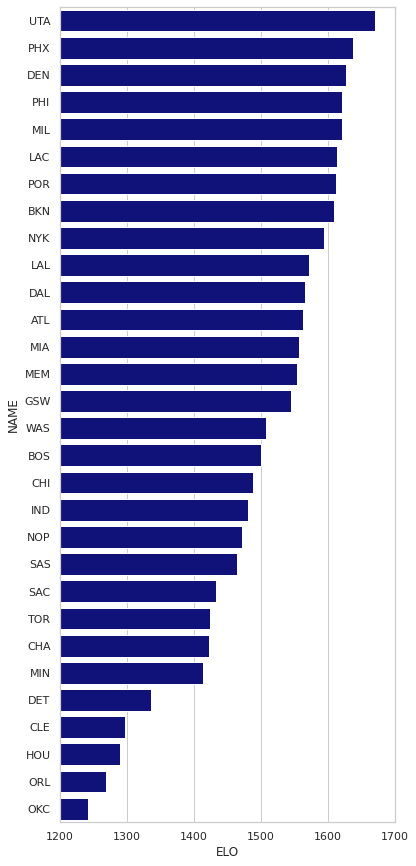

In [ ]:
sn.set_theme(style="whitegrid")
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))
sn.set_color_codes("pastel")
sn.set_color_codes("pastel")
sn.barplot(x="ELO", y="NAME", data=sorted_team_elo,
            label="ELO", color="darkblue")
ax.set(xlim=(1200, 1700));

##  **Incorporating player efficiency**
Basketball is a sport where key players can have substantial impact on the team's success. Therefore, it is crucial to incorporate this information in the modelling dataset.
This sounds straightforward in theory but in practice there is an important issue to be adressed: There is no all-encompassing metric for efficiency in basketball. The most popular one is the Player efficiency rating (PER) developed by John Hollinger.
Given that not all figures that are required in the calculation are available in the dataset, a different efficiency measure was used: (taken from Breakthroughbasketball)
## Efficiency = Pts + Rebs + Ast + Stl + Blk – (TO + FG Misses + FT Misses)
One benefit that I found in this statistic is that it does filter for games played as the number of all of these figures increases with more games. This means that there is no need for an arbitrary cut-off for season games. Using this efficiency measure the following features were added to the dataset:
1) Players in a team that had a top 30 efficiency rating last season.
2) A measure of "team" efficiency by summing the last season efficiency of all players per team per game

The player efficiency figures for the 2019 season can be seen below:

In [ ]:
# https://en.wikipedia.org/wiki/Player_efficiency_rating

In [ ]:
details['FGMISSES'] = details.FGA - details.FGM
details['FTMISSES'] = details.FTA - details.FTM
details['EFF'] = details.PTS + details.REB + details.AST + details.STL + details.BLK - (details.TO + details.FGMISSES + details.FTMISSES)

# Creating the efficiency dataset
eff = details[['PLAYER_NAME', 'PLAYER_ID', 'SEASON', 'EFF']].copy()
eff.dropna(inplace=True)
eff = eff.groupby(['PLAYER_NAME', 'PLAYER_ID', 'SEASON'], as_index=False).sum()
eff.sort_values('EFF', ascending=False, inplace=True)
top_players = eff.groupby('SEASON', as_index=False).head(300).copy()  ####
top_players['NEXT_SEASON'] = top_players.SEASON + 1
eff['NEXT_SEASON'] = eff.SEASON + 1

# Efficiency per game per team
per_game_eff = details.loc[details.COMMENT.isnull()][['GAME_ID', 'TEAM_ID', 'PLAYER_ID', 'SEASON']].merge(eff, left_on=['PLAYER_ID', 'SEASON'], right_on=['PLAYER_ID', 'NEXT_SEASON'], how='left')
pge = per_game_eff.groupby(['GAME_ID', 'TEAM_ID'], as_index=False).EFF.mean()
pge.dropna(inplace= True)

# Top players based on efficiecy for the 2019 season
top_players.loc[top_players.SEASON == 2019, ['PLAYER_NAME', 'EFF']].T

,2971,3564,6307,5181,3149,2328,493,5318,7163,664,1692,8038,318,2226,2021,860,7180,4278,1418,4613,701,6328,3865,4502,4056,7935,899,2356,8553,6123,7394,4864,4143,4802,3701,1089,6467,7561,5069,4475,5021,4182,4954,7670,2262,1060,4602,6954,3361,2108,1522,7716,102,6083,7802,8133,8448,4665,6207,810,22,1784,433,3513,1992,2676,1461,1496,2766,4679,5240,6966,3855,5281,3130,7364,3032,2077,1974,5406,1609,5137,5628,1772,3301,7942,6367,160,4100,3688,2845,6053,6157,4093,1510,6556,5653,2187,5556,2470,7902,4687,2439,5813,2702,1968,1023,887,6446,2170,2391,5948,4310,3426,3017,5564,6448,6927,2193,8137,3002,2083,2070,3291,3936,7792,2296,1837,4785,7752,2363,3388,7830,5151,3916,8410,4401,791,7129,1032,6237,1192,1225,7155,2665,7380,1500,1976,803,8470,2614,6347,3344,3040,7709,1831,1711,3456,4533,2418,8121,6572,7851,6117,6681,4434,8272,2919,5119,4659,7392,6490,3955,5716,7165,6525,4448,2175,185,4730,8095,3847,2404,4982,4738,4935,746,7734,2885,5006,6088,7770,2871,1565,1052,1137,2477,606,1810,1979,35,7076,1622,3375,2745,4288,1120,696,5049,1841,2851,3459,5971,8195,5802,3397,8011,6475,3703,5638,5431,1683,5438,1347,851,5486,640,5856,4824,6724,8437,6129,451,6386,7693,3552,5910,2830,6033,3212,5338,3248,8602,7980,5708,5880,1124,5112,6294,4347,174,2822,7537,651,3278,4789,2506,4976,2273,7864,3133,2905,4193,4352,2656,1041,7002,1502,2002,4489,5721,8023,3576,5003,7518,4537,3053,2927,3899,1839,7197,1752,5600,2690,7397,4342,5233,1309,773,4855,1732,6186,4037,4620,8416,51,8337,7622,6879,7433
PLAYER_NAME,Giannis Antetokounmpo,James Harden,Nikola Jokic,LeBron James,Hassan Whiteside,Domantas Sabonis,Anthony Davis,Luka Doncic,Rudy Gobert,Bam Adebayo,Damian Lillard,Trae Young,Andre Drummond,Devin Booker,DeMar DeRozan,Bradley Beal,Russell Westbrook,Jonas Valanciunas,Chris Paul,Kawhi Leonard,Ben Simmons,Nikola Vucevic,Jayson Tatum,Julius Randle,Jimmy Butler,Tobias Harris,Brandon Ingram,Donovan Mitchell,Zach LaVine,Montrezl Harrell,Shai Gilgeous-Alexander,Khris Middleton,Joel Embiid,Kevin Love,Jarrett Allen,CJ McCollum,Pascal Siakam,Spencer Dinwiddie,LaMarcus Aldridge,Jrue Holiday,Kyle Lowry,John Collins,Kristaps Porzingis,Steven Adams,Devonte' Graham,Buddy Hield,Karl-Anthony Towns,Ricky Rubio,Ja Morant,Dennis Schroder,Collin Sexton,T.J. Warren,Al Horford,Mitchell Robinson,Terry Rozier,Tristan Thompson,Will Barton,Kelly Oubre Jr.,Nemanja Bjelica,Bojan Bogdanovic,Aaron Gordon,Danilo Gallinari,Andrew Wiggins,Jamal Murray,DeAndre Jordan,Eric Bledsoe,Christian Wood,Clint Capela,Evan Fournier,Kemba Walker,Lonzo Ball,Robert Covington,Jaylen Brown,Lou Williams,Harrison Barnes,Serge Ibaka,Gordon Hayward,Dejounte Murray,De'Aaron Fox,Malcolm Brogdon,D'Angelo Russell,Larry Nance Jr.,Markelle Fultz,Daniel Theis,Ivica Zubac,Tomas Satoransky,OG Anunoby,Alec Burks,Joe Ingles,Jaren Jackson Jr.,Fred VanVleet,Miles Bridges,Myles Turner,Joe Harris,Cody Zeller,Paul George,Marquese Chriss,Derrick Rose,Marcus Morris Sr.,Dwight Howard,Tim Hardaway Jr.,Kendrick Nunn,Duncan Robinson,Maxi Kleber,Eric Paschall,Davis Bertans,Brook Lopez,Brandon Clarke,P.J. Tucker,Derrick Favors,Dorian Finney-Smith,Mikal Bridges,Jordan Clarkson,Jae Crowder,Goran Dragic,Marcus Smart,P.J. Washington,Richaun Holmes,Derrick White,Troy Brown Jr.,Glenn Robinson III,Delon Wright,Deandre Ayton,Ish Smith,Jerami Grant,Terrence Ross,Dillon Brooks,Dario Saric,Kevin Huerter,Taurean Prince,Donte DiVincenzo,JaVale McGee,Thaddeus Young,Lauri Markkanen,Jeff Teague,Wendell Carter Jr.,Josh Hart,Bobby Portis,Royce O'Neale,Bruce Brown,Nerlens Noel,Carmelo Anthony,Cedi Osman,Rudy Gay,Enes Kanter,Seth Curry,Coby White,De'Andre Hunter,Bogdan Bogdanovic,Willie Cauley-Stein,Elfrid Payton,Norman Powell,JJ Redick,Gorgui Dieng,T.J. McConnell,Danuel House Jr.,Damion Lee,Jakob Poeltl,Justin Holiday,Draymond Green,Trey Lyles,Paul Millsap,Thomas Bryant,Monte Morris,RJ Barrett,Josh Okogie,Tyus Jones,George Hill,Langston Galloway,Kelly Olynyk,Shabazz Napier,Patrick Beverley,Jeremy Lamb,Mason Plumlee,Rui Hachimura,Patty Mills,Josh Richardson,Derrick Jones Jr.

In [ ]:
# Top players based on efficiecy for the De season
top_players.loc[top_players.SEASON == 2020, ['PLAYER_NAME', 'EFF']].T

,6308,2972,4503,6329,7181,5319,7595,1693,2329,7164,3866,8603,665,1419,4279,1497,8039,4144,861,2071,2227,4865,8554,2022,4614,4603,4057,5050,2666,3565,900,2078,7936,7803,1975,5911,3856,4183,6928,3702,6468,5182,702,4660,434,4476,4983,6557,5407,2419,6682,5949,3362,7831,2357,1523,495,1061,3457,6124,3131,6348,7710,5717,1348,3302,4769,2846,6054,1501,3937,6449,4101,4311,811,792,3428,4646,1090,1024,6967,4094,3514,7903,319,5022,3460,4955,5071,2109,7130,5241,2084,1462,5972,5007,6955,1138,8229,6187,3267,3033,2297,2364,4786,1773,2471,2440,7671,8411,1842,2405,2677,6989,7233,888,1033,4666,8196,7395,6238,494,1993,6288,3900,6158,4534,1193,6514,2263,2392,1811,7166,4688,4856,4680,6880,7003,2171,804,7156,2188,4402,6368,8449,5565,4722,6857,4419,5557,3427,7398,1840,23,1610,5152,6476,3696,4449,3266,8134,4564,2205,7381,1511,1785,6573,4739,2767,4235,2906,5693,1131,1566,2446,7943,3122,3018,161,5432,5282,7769,6811,8273,3848,7737,6143,6526,2615,1520,7365,747,3241,3251,8492,186,1125,1969,7835,8515,1753,7793,4731,4842,8313,761,1226,3376,4485,6118,2785,2478,3057,5303,4752,1980,5814,3418,1053,5339,5234,6597,7623,2176,5138,2194,6089,4353,7735,2068,7981,175,2032,5113,103,338,2422,2872,7694,5487,7771,5639,6084,8471,2928,3577,2100,1712,1481,3389,8230,452,6274,3620,1623,1838,607,3292,2117,5722,6453,2823,2852,3553,8024,2257,7538,3956,2003,4490,4343,3150,3917,5439,7753,3467,852,36,4435,4803,6680,4825,6725,8403,3261,7232,6623,3054,2587,5399,7581,3041,8166,1977,5070,6130,6292,6405,6447,164
PLAYER_NAME,Nikola Jokic,Giannis Antetokounmpo,Julius Randle,Nikola Vucevic,Russell Westbrook,Luka Doncic,Stephen Curry,Damian Lillard,Domantas Sabonis,Rudy Gobert,Jayson Tatum,Zion Williamson,Bam Adebayo,Chris Paul,Jonas Valanciunas,Clint Capela,Trae Young,Joel Embiid,Bradley Beal,Deandre Ayton,Devin Booker,Khris Middleton,Zach LaVine,DeMar DeRozan,Kawhi Leonard,Karl-Anthony Towns,Jimmy Butler,Kyrie Irving,Enes Kanter,James Harden,Brandon Ingram,Dejounte Murray,Tobias Harris,Terry Rozier,De'Aaron Fox,Michael Porter Jr.,Jaylen Brown,John Collins,Richaun Holmes,Jarrett Allen,Pascal Siakam,LeBron James,Ben Simmons,Kelly Olynyk,Andrew Wiggins,Jrue Holiday,Kyle Anderson,Paul George,Malcolm Brogdon,Draymond Green,RJ Barrett,Mikal Bridges,Ja Morant,Thaddeus Young,Donovan Mitchell,Collin Sexton,Anthony Edwards,Buddy Hield,Jakob Poeltl,Montrezl Harrell,Harrison Barnes,Norman Powell,T.J. McConnell,Mason Plumlee,Chris Boucher,Ivica Zubac,Kevin Durant,Fred VanVleet,Miles Bridges,Coby White,Jerami Grant,P.J. Washington,Joe Ingles,Jordan Clarkson,Bojan Bogdanovic,Bobby Portis,Jae'Sean Tate,Keldon Johnson,CJ McCollum,Brook Lopez,Robert Covington,Joe Harris,Jamal Murray,Tim Hardaway Jr.,Andre Drummond,Kyle Lowry,Jalen Brunson,Kristaps Porzingis,LaMelo Ball,Dennis Schroder,Royce O'Neale,Lonzo Ball,Delon Wright,Christian Wood,Mike Conley,Kyle Kuzma,Ricky Rubio,Caris LeVert,Tyrese Haliburton,Naz Reid,Isaiah Stewart,Gordon Hayward,Dillon Brooks,Donte DiVincenzo,Kevin Huerter,Daniel Theis,Dwight Howard,Duncan Robinson,Steven Adams,Wendell Carter Jr.,Darius Garland,Doug McDermott,Eric Bledsoe,Robert Williams III,Saddiq Bey,Brandon Clarke,Bruce Brown,Kelly Oubre Jr.,Tyler Herro,Shai Gilgeous-Alexander,Nerlens Noel,Anthony Davis,DeAndre Jordan,Nicolas Batum,Jeff Green,Myles Turner,Justin Holiday,Carmelo Anthony,Patrick Williams,Devonte' Graham,Dorian Finney-Smith,Danny Green,Rui Hachimura,Kendrick Nunn,Khem Birch,Kemba Walker,Reggie Jackson,Robin Lopez,Derrick Favors,Bogdan Bogdanovic,Rudy Gay,Derrick Rose,Josh Hart,OG Anunoby,Will Barton,Marcus Smart,Kenrich Williams,Reggie Bullock,Josh Jackson,Marcus Morris Sr.,Jae Crowder,Shake Milton,Darius Bazley,Aaron Gordon,D'Angelo Russell,Lauri Markkanen,Pat Connaughton,Jarred Vanderbilt,Josh Richardson,Isaiah Roby,Tristan Thompson,Jusuf Nurkic,Desmond Bane,Seth Curry,Cody Zeller,Danilo Gallinari,Paul Millsap,Kentavious Caldwell-Pope,Evan Fournier,John Wall,Gary Trent Jr.,Marvin Bagley III,Cameron Payne,Cory Joseph,Dwayne Bacon,Tomas Satoransky,Hamidou Diallo,Go

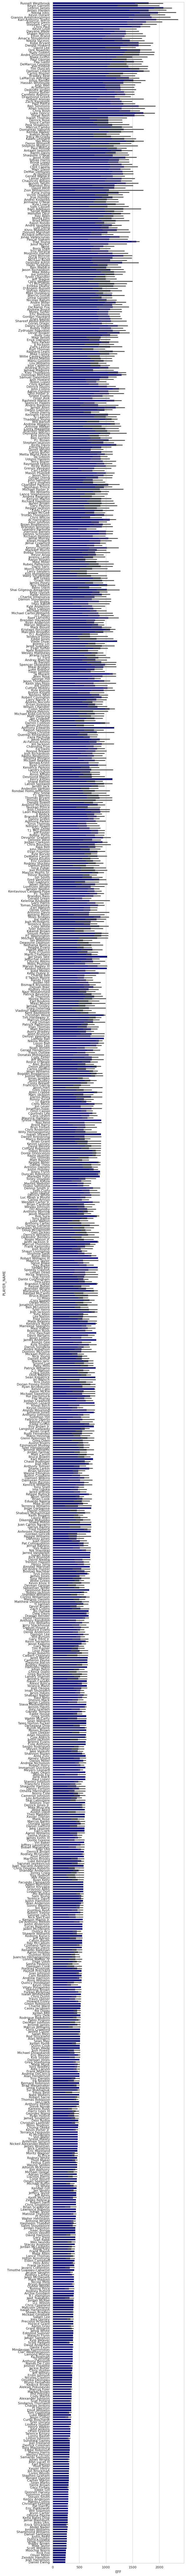

In [ ]:
plt.figure(figsize=(8,160))
font = {'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 2}
plt.rc('font', **font)
sn.set_theme(style="whitegrid")
sn.set_color_codes("pastel")
sn.set_color_codes("pastel")
sn.barplot(x="EFF", y="PLAYER_NAME", data=top_players,
            label="ELO", color="darkblue");
#ax.set(xlim=(1200, 2000));

In [ ]:
top_players_per_game = details.loc[details.COMMENT.isnull()][['GAME_ID', 'TEAM_ID', 'PLAYER_ID', 'SEASON']].merge(top_players, left_on=['PLAYER_ID', 'SEASON'], right_on=['PLAYER_ID', 'NEXT_SEASON'], how='left')
top_players_per_game = top_players_per_game.groupby(['GAME_ID', 'TEAM_ID', 'SEASON_x']).PLAYER_NAME.agg(lambda x: x.notnull().sum()).reset_index()
top_players_per_game.columns = ['GAME_ID', 'TEAM_ID', 'SEASON', 'TOP_PLAYERS']
#top_players_per_game.drop(columns='SEASON', inplace=True)

In [ ]:
# CHECK
top_players_per_game.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42792 entries, 0 to 42791
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   GAME_ID      42792 non-null  int64
 1   TEAM_ID      42792 non-null  int64
 2   SEASON       42792 non-null  int64
 3   TOP_PLAYERS  42792 non-null  int64
dtypes: int64(4)
memory usage: 1.3 MB


# Incorporating team fatigue
Players are humans and do get tired throughout the season. In order to measure this in the dataset the following variables are added:

**HG_7days**: Home games in the last 7 days

**AG_7days**: Away games in the last 7 days

**G_7days**: Total games in the last 7 days

**BACK2BACK**: Whether a team played a game the night before


In [ ]:
games_played = pd.melt(games_short, id_vars = ['GAME_ID', 'GAME_DATE_EST'], value_vars = ['HOME_TEAM_ID', 'VISITOR_TEAM_ID']).set_index('GAME_DATE_EST')
games_played['HOME_GAME'] = np.where(games_played.variable == "HOME_TEAM_ID", True, False)
games_played.drop(columns = 'variable', inplace = True)
games_played.rename(columns = {'value':'TEAM_ID'}, inplace = True)
games_played.sort_values(['TEAM_ID', 'GAME_DATE_EST'], inplace = True)

# Games in the last week # FAIRE DES TESTS 
games_played['HG_7days'] = games_played.groupby('TEAM_ID').HOME_GAME.apply(lambda x: x.rolling(window = "7d", closed='left', min_periods=0).sum())  # 14d
games_played['AG_7days'] = games_played.groupby('TEAM_ID').HOME_GAME.apply(lambda x: (~x).rolling(window = "7d", closed='left', min_periods=0).sum())
games_played['G_7days'] = games_played['HG_7days'] + games_played['AG_7days']

In [ ]:
# Back to back games
games_played.reset_index(inplace=True)
games_played['PAST_GAME'] = games_played.groupby(['TEAM_ID']).GAME_DATE_EST.transform(lambda x: x.shift(periods=1))
games_played['BACK2BACK'] = np.where((games_played.GAME_DATE_EST - games_played.PAST_GAME).dt.days == 1, 1, 0)
games_played.drop(columns = ['PAST_GAME', 'GAME_DATE_EST', 'HOME_GAME'], inplace=True)

In [ ]:
# CHECK
games_played.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42792 entries, 0 to 42791
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   GAME_ID    42792 non-null  int64  
 1   TEAM_ID    42792 non-null  int64  
 2   HG_7days   42792 non-null  float64
 3   AG_7days   42792 non-null  float64
 4   G_7days    42792 non-null  float64
 5   BACK2BACK  42792 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 2.0 MB


In [ ]:
########################################

In [ ]:
### Création dataset input_data ###
# Combining all the data to create the full dataset
input_data = pd.merge_asof(games_short, ranking_short, left_on = 'GAME_DATE_EST', right_on = 'STANDINGSDATE', left_by = 'HOME_TEAM_ID', right_by = 'TEAM_ID', allow_exact_matches = False)
input_data = input_data.loc[~input_data.TEAM_ID.isnull()]
input_data = pd.merge_asof(input_data, ranking_short.add_suffix("_VISITOR"), left_on = 'GAME_DATE_EST', right_on = 'STANDINGSDATE_VISITOR', left_by = 'VISITOR_TEAM_ID', right_by = 'TEAM_ID_VISITOR', allow_exact_matches = False)

input_data.loc[(input_data.GAME_DATE_EST.dt.month <= 12) & (input_data.GAME_DATE_EST.dt.month > 9) & (input_data.G > 50), ['G', 'W', 'L', 'HOME_W', 'HOME_L', 'AWAY_W', 'AWAY_L']] = 0
input_data.loc[(input_data.GAME_DATE_EST.dt.month <= 12) & (input_data.GAME_DATE_EST.dt.month > 9) & (input_data.G_VISITOR > 50), ['G_VISITOR', 'W_VISITOR', 'L_VISITOR', 'HOME_W_VISITOR', 'HOME_L_VISITOR', 'AWAY_W_VISITOR', 'AWAY_L_VISITOR']] = 0

#Adding top players
input_data = input_data.merge(top_players_per_game, left_on=['HOME_TEAM_ID', 'GAME_ID'], right_on=['TEAM_ID', 'GAME_ID'], suffixes=('','_something'))
input_data = input_data.merge(top_players_per_game, left_on=['VISITOR_TEAM_ID', 'GAME_ID'], right_on=['TEAM_ID', 'GAME_ID'], suffixes=('','_VISITOR'))
input_data.drop(columns=['TEAM_ID_something', 'TEAM_ID_VISITOR'], inplace=True)

#Adding player efficiency
input_data = input_data.merge(pge, left_on=['HOME_TEAM_ID', 'GAME_ID'], right_on=['TEAM_ID', 'GAME_ID'], suffixes=('','_something'))
input_data = input_data.merge(pge, left_on=['VISITOR_TEAM_ID', 'GAME_ID'], right_on=['TEAM_ID', 'GAME_ID'], suffixes=('','_VISITOR'))
input_data.drop(columns=['TEAM_ID_something', 'TEAM_ID_VISITOR'], inplace=True)

#Adding team fatigue
input_data = input_data.merge(games_played, left_on=['HOME_TEAM_ID', 'GAME_ID'], right_on=['TEAM_ID', 'GAME_ID'], suffixes=('','_something'))
input_data = input_data.merge(games_played, left_on=['VISITOR_TEAM_ID', 'GAME_ID'], right_on=['TEAM_ID', 'GAME_ID'], suffixes=('','_VISITOR'))
input_data.drop(columns=['TEAM_ID_something', 'TEAM_ID_VISITOR'], inplace=True)

In [ ]:
# CHECK
input_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20209 entries, 0 to 20208
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   GAME_ID                20209 non-null  int64         
 1   GAME_DATE_EST          20209 non-null  datetime64[ns]
 2   SEASON                 20209 non-null  int64         
 3   HOME_TEAM_ID           20209 non-null  int64         
 4   VISITOR_TEAM_ID        20209 non-null  int64         
 5   HOME_TEAM_WINS         20209 non-null  int64         
 6   result                 20209 non-null  object        
 7   TEAM_ID                20209 non-null  float64       
 8   STANDINGSDATE          20209 non-null  datetime64[ns]
 9   CONFERENCE             20209 non-null  object        
 10  TEAM                   20209 non-null  object        
 11  G                      20209 non-null  float64       
 12  W                      20209 non-null  float64       
 13  L

In [ ]:
# Adding ELO
input_data = input_data.merge(elo_data[['GAME_ID', 'HOME_ELO', 'VISITOR_ELO']])

input_data['HOME_TEAM'] = input_data['HOME_TEAM_ID'].map(teams_dict)
input_data['VISITOR_TEAM'] = input_data['VISITOR_TEAM_ID'].map(teams_dict)

#input_data = input_data.drop(columns = ['HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'TEAM_ID', 'TEAM', 'TEAM_ID_x', 'TEAM_ID_y', 'STANDINGSDATE', 'TEAM_VISITOR', 'STANDINGSDATE_VISITOR'])
# input_data = input_data.drop(columns = ['TEAM', 'TEAM_VISITOR'])              # le 19 11 21
input_data['ELO_DIFF'] = input_data.HOME_ELO - input_data.VISITOR_ELO
input_data['TOP_PLAYER_DIFF'] = input_data.TOP_PLAYERS - input_data.TOP_PLAYERS_VISITOR
#input_data['MISSING_PLAYER_DIFF'] = input_data.MISSING_PLAYERS - input_data.MISSING_PLAYERS_VISITOR
input_data['EFF_DIFF'] = input_data.EFF - input_data.EFF_VISITOR
input_data['MONTH'] = input_data.GAME_DATE_EST.dt.month

input_data.drop(columns = ['CONFERENCE', 'CONFERENCE_VISITOR', 'GAME_DATE_EST'], inplace=True)  ##'HOME_TEAM', 'VISITOR_TEAM'

In [ ]:
# CHECK
input_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20209 entries, 0 to 20208
Data columns (total 47 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   GAME_ID                20209 non-null  int64         
 1   SEASON                 20209 non-null  int64         
 2   HOME_TEAM_ID           20209 non-null  int64         
 3   VISITOR_TEAM_ID        20209 non-null  int64         
 4   HOME_TEAM_WINS         20209 non-null  int64         
 5   result                 20209 non-null  object        
 6   TEAM_ID                20209 non-null  float64       
 7   STANDINGSDATE          20209 non-null  datetime64[ns]
 8   TEAM                   20209 non-null  object        
 9   G                      20209 non-null  float64       
 10  W                      20209 non-null  float64       
 11  L                      20209 non-null  float64       
 12  HOME_W                 20209 non-null  float64       
 13  H

In [ ]:
input_data.isna().sum()

GAME_ID                  0
SEASON                   0
HOME_TEAM_ID             0
VISITOR_TEAM_ID          0
HOME_TEAM_WINS           0
result                   0
TEAM_ID                  0
STANDINGSDATE            0
TEAM                     0
G                        0
W                        0
L                        0
HOME_W                   0
HOME_L                   0
AWAY_W                   0
AWAY_L                   0
STANDINGSDATE_VISITOR    0
TEAM_VISITOR             0
G_VISITOR                0
W_VISITOR                0
L_VISITOR                0
HOME_W_VISITOR           0
HOME_L_VISITOR           0
AWAY_W_VISITOR           0
AWAY_L_VISITOR           0
SEASON_something         0
TOP_PLAYERS              0
SEASON_VISITOR           0
TOP_PLAYERS_VISITOR      0
EFF                      0
EFF_VISITOR              0
HG_7days                 0
AG_7days                 0
G_7days                  0
BACK2BACK                0
HG_7days_VISITOR         0
AG_7days_VISITOR         0
G

In [ ]:
#input_data = input_data.dropna(axis=0)

In [ ]:
### Création dataset NEW -> COTES ###

In [ ]:
NEW=pd.read_csv("/content/drive/MyDrive/DATASET NBA/data complémentaires/KAGGLE Dataset with all NBA games from 2004 season to dec 2020/ODD2019 (1).txt")


In [ ]:
NEW.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1174 entries, 0 to 1173
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   TIME      1174 non-null   object
 1   HOME      1174 non-null   object
 2   AWAY      1174 non-null   object
 3   Result    1174 non-null   object
 4   1         1174 non-null   object
 5   2         1174 non-null   object
 6   DATE      1174 non-null   int64 
 7   Year      1174 non-null   int64 
 8   Colonne3  1174 non-null   object
 9   MONTH     1174 non-null   int64 
 10  DATEF     1174 non-null   object
dtypes: int64(3), object(8)
memory usage: 101.0+ KB


In [ ]:
NEW.HOME.unique()

array(['Los Angeles Clippers ', 'Oklahoma City Thunder ',
       'Denver Nuggets ', 'Dallas Mavericks ', 'San Antonio Spurs ',
       'Orlando Magic ', 'Toronto Raptors ', 'Detroit Pistons ',
       'New Orleans Pelicans ', 'Los Angeles Lakers ',
       'Minnesota Timberwolves ', 'New York Knicks ', 'Brooklyn Nets ',
       'Houston Rockets ', 'Milwaukee Bucks ', 'Philadelphia 76ers ',
       'Phoenix Suns ', 'Washington Wizards ', 'Sacramento Kings ',
       'Charlotte Hornets ', 'Boston Celtics ', 'Cleveland Cavaliers ',
       'Memphis Grizzlies ', 'Atlanta Hawks ', 'Miami Heat ',
       'Indiana Pacers ', 'Portland Trail Blazers ',
       'Golden State Warriors ', 'Chicago Bulls ', 'Utah Jazz ',
       'Team USA ', 'Team Giannis '], dtype=object)

In [ ]:
NEW.AWAY.unique()

array([' New Orleans Pelicans\xa0', ' Utah Jazz\xa0', ' Miami Heat\xa0',
       ' Houston Rockets\xa0', ' Sacramento Kings\xa0',
       ' Golden State Warriors', ' Utah Jazz', ' San Antonio Spurs',
       ' Oklahoma City Thunder', ' Dallas Mavericks',
       ' Memphis Grizzlies', ' Boston Celtics', ' Miami Heat',
       ' Atlanta Hawks', ' Charlotte Hornets', ' Indiana Pacers',
       ' Minnesota Timberwolves', ' Portland Trail Blazers',
       ' Denver Nuggets', ' Chicago Bulls', ' Toronto Raptors',
       ' Boston Celtics\xa0', ' Orlando Magic', ' Cleveland Cavaliers',
       ' Detroit Pistons', ' Philadelphia 76ers', ' Milwaukee Bucks',
       ' Houston Rockets', ' Los Angeles Lakers', ' Brooklyn Nets',
       ' New York Knicks', ' San Antonio Spurs\xa0',
       ' Portland Trail Blazers\xa0', ' Washington Wizards\xa0',
       ' Los Angeles Lakers\xa0', ' Philadelphia 76ers\xa0',
       ' Washington Wizards', ' New Orleans Pelicans', ' Phoenix Suns',
       ' Memphis Grizzlies\xa0', 

In [ ]:
dictNEW = {' Atlanta Hawks': 'ATL',
 'Boston Celtics ': 'BOS',
 'Cleveland Cavaliers ': 'CLE',
 'New Orleans Pelicans ': 'NOP',
 'Chicago Bulls ': 'CHI',
 'Dallas Mavericks ': 'DAL',
 'Denver Nuggets ': 'DEN',
 'Golden State Warriors ': 'GSW',
 'Houston Rockets ': 'HOU',
 'Los Angeles Clippers ': 'LAC',
 'Los Angeles Lakers ': 'LAL',
 'Miami Heat ': 'MIA',
 'Milwaukee Bucks ': 'MIL',
 'Minnesota Timberwolves ': 'MIN',
 'Brooklyn Nets ': 'BKN',
 'New York Knicks ': 'NYK',
 'Orlando Magic ': 'ORL',
 'Indiana Pacers ': 'IND',
 'Philadelphia 76ers ': 'PHI',
 'Phoenix Suns ': 'PHX',
 'Portland Trail Blazers ': 'POR',
 'Sacramento Kings ': 'SAC',
 'San Antonio Spurs ': 'SAS',
 'Oklahoma City Thunder ': 'OKC',
 'Toronto Raptors ': 'TOR',
 'Utah Jazz ': 'UTA',
 'Memphis Grizzlies ': 'MEM',
 'Washington Wizards ': 'WAS',
 'Detroit Pistons ': 'DET',
 'Charlotte Hornets ': 'CHA'}

dictNEW2 = {'Atlanta Hawks ': 'ATL',
 ' Boston Celtics': 'BOS',
 ' Boston Celtics\xa0': 'BOS',
 ' Cleveland Cavaliers': 'CLE',
 ' New Orleans Pelicans': 'NOP',
 ' New Orleans Pelicans\xa0': 'NOP',
 ' Chicago Bulls': 'CHI',
 ' Dallas Mavericks': 'DAL',
 ' Dallas Mavericks\xa0':'DAL',
 ' Denver Nuggets': 'DEN',
 ' Denver Nuggets\xa0':'DEN',
 ' Golden State Warriors': 'GSW',
 ' Houston Rockets': 'HOU',
 ' Houston Rockets\xa0': 'HOU',
 ' Los Angeles Clippers': 'LAC',
 ' Los Angeles Clippers\xa0': 'LAC',
 ' Los Angeles Lakers': 'LAL',
 ' Los Angeles Lakers\xa0': 'LAL',
 ' Miami Heat': 'MIA',
 ' Miami Heat\xa0': 'MIA',
 ' Milwaukee Bucks': 'MIL',
 ' Milwaukee Bucks\xa0': 'MIL',
 ' Minnesota Timberwolves': 'MIN',
 ' Minnesota Timberwolves\xa0': 'MIN',
 ' Brooklyn Nets': 'BKN',
 ' Brooklyn Nets\xa0': 'BKN',
 ' New York Knicks': 'NYK',
 ' New York Knicks\xa0': 'NYK',
 ' Orlando Magic': 'ORL',
 ' Orlando Magic\xa0': 'ORL',
 ' Indiana Pacers': 'IND',
 ' Indiana Pacers\xa0': 'IND',
 ' Philadelphia 76ers': 'PHI',
 ' Philadelphia 76ers\xa0': 'PHI',
 ' Phoenix Suns': 'PHX',
 ' Phoenix Suns\xa0': 'PHX',
 ' Portland Trail Blazers': 'POR',
 ' Portland Trail Blazers\xa0': 'POR',
 ' Sacramento Kings': 'SAC',
 ' Sacramento Kings\xa0': 'SAC',
 ' San Antonio Spurs': 'SAS',
 ' San Antonio Spurs\xa0': 'SAS',
 ' Oklahoma City Thunder': 'OKC',
 ' Oklahoma City Thunder\xa0': 'OKC',
 ' Toronto Raptors': 'TOR',
 ' Toronto Raptors\xa0': 'TOR',
 ' Utah Jazz': 'UTA',
 ' Utah Jazz\xa0': 'UTA',
 ' Memphis Grizzlies': 'MEM',
 ' Memphis Grizzlies\xa0': 'MEM',
 ' Washington Wizards': 'WAS',
 ' Washington Wizards\xa0': 'WAS',
 ' Detroit Pistons': 'DET',
 ' Charlotte Hornets': 'CHA',
 ' Charlotte Hornets\xa0': 'CHA'}

In [ ]:
NEW['HOME'] = NEW['HOME'].map(dictNEW)  
NEW['AWAY'] = NEW['AWAY'].map(dictNEW2)  

NEW.DATEF = pd.to_datetime(NEW.DATEF)
# ranking['STANDINGSDATE'] = pd.to_datetime(ranking['STANDINGSDATE'])

In [ ]:
# CHECK
NEW.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1174 entries, 0 to 1173
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   TIME      1174 non-null   object        
 1   HOME      1138 non-null   object        
 2   AWAY      1139 non-null   object        
 3   Result    1174 non-null   object        
 4   1         1174 non-null   object        
 5   2         1174 non-null   object        
 6   DATE      1174 non-null   int64         
 7   Year      1174 non-null   int64         
 8   Colonne3  1174 non-null   object        
 9   MONTH     1174 non-null   int64         
 10  DATEF     1174 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 101.0+ KB


In [ ]:
NEW = NEW.dropna(axis=0)

In [ ]:
#NEW = NEW.loc[(NEW.Year ==2020)]

In [ ]:
### CONCATENATION des datasets input_date & NEW ###

In [ ]:
# input_data = input_data.merge(NEW, left_on=['STANDINGSDATE', 'HOME_TEAM', 'VISITOR_TEAM'], right_on=['DATEF', 'HOME','AWAY']) # jointure KO avec ces 3 clés , suffixes=('','_something'))
# input_data = input_data.merge(NEW, left_on=['STANDINGSDATE', 'result'], right_on=['DATEF', 'Result']) #, suffixes=('','_something')) # NOK
# input_data = input_data.merge(NEW, left_on=['STANDINGSDATE','HOME_TEAM'], right_on=['DATEF','HOME']) #, suffixes=('','_something')) # KO équipes AWAY
# input_data = input_data.merge(NEW, left_on=['STANDINGSDATE','VISITOR_TEAM'], right_on=['DATEF','AWAY']) # KO équipes HOME
# input_data = input_data.merge(NEW, left_on=['STANDINGSDATE','HOME_TEAM','VISITOR_TEAM'], right_on=['DATEF','HOME','AWAY']) # jointure KO avec ces 3 clés
# input_data = input_data.merge(NEW, left_on=['result','VISITOR_TEAM'], right_on=['Result','AWAY']) # KO car beaucoup de scoring identiques!

input_data = input_data.merge(NEW, left_on=['result', 'HOME_TEAM','VISITOR_TEAM'], right_on=['Result','HOME','AWAY']) # OK avec ces 3 clés


In [ ]:
input_data.sample(3)

,GAME_ID,SEASON,HOME_TEAM_ID,VISITOR_TEAM_ID,HOME_TEAM_WINS,result,TEAM_ID,STANDINGSDATE,TEAM,G,W,L,HOME_W,HOME_L,AWAY_W,AWAY_L,STANDINGSDATE_VISITOR,TEAM_VISITOR,G_VISITOR,W_VISITOR,L_VISITOR,HOME_W_VISITOR,HOME_L_VISITOR,AWAY_W_VISITOR,AWAY_L_VISITOR,SEASON_something,TOP_PLAYERS,SEASON_VISITOR,TOP_PLAYERS_VISITOR,EFF,EFF_VISITOR,HG_7days,AG_7days,G_7days,BACK2BACK,HG_7days_VISITOR,AG_7days_VISITOR,G_7days_VISITOR,BACK2BACK_VISITOR,HOME_ELO,VISITOR_ELO,HOME_TEAM,VISITOR_TEAM,ELO_DIFF,TOP_PLAYER_DIFF,EFF_DIFF,MONTH_x,TIME,HOME,AWAY,Result,1,2,DATE,Year,Colonne3,MONTH_y,DATEF
612,21900644,2019,1610612748,1610612758,1,118:113,1.610613e+09,2020-01-19,Miami,42.0,29.0,13.0,18.0,1.0,11.0,12.0,2020-01-19,Sacramento,42,15,27,8,13,7,14,2019,6,2019,9,609.0,1045.444444,1.0,2.0,3.0,1,2.0,1.0,3.0,0,1683.472599,1420.357474,MIA,SAC,263.115126,-3,-436.444444,1,22:00,MIA,SAC,118:113,1.57,2.45,20,2020,Janv,1,2020-01-20
513,21900535,2019,1610612748,1610612757,1,122:111,1.610613e+09,2020-01-04,Miami,35.0,25.0,10.0,16.0,1.0,9.0,9.0,2020-01-04,Portland,36,15,21,8,9,7,12,2019,5,2019,4,553.5,654.750000,1.0,2.0,3.0,0,1.0,2.0,3.0,0,1668.578149,1481.790842,MIA,POR,186.787307,1,-101.250000,1,23:00,MIA,POR,122:111,1.46,2.75,5,2020,Janv,1,2020-01-05
627,21900662,2019,1610612745,1610612743,1,121:105,1.610613e+09,2020-01-21,Houston,42.0,26.0,16.0,14.0,7.0,12.0,9.0,2020-01-21,Denver,43,30,13,17,6,13,7,2019,7,2019,7,956.6,779.777778,3.0,0.0,3.0,0,2.0,2.0,4.0,0,1682.216021,1582.633637,HOU,DEN,99.582385,0,176.822222,1,01:00,HOU,DEN,121:105,1.18,5.06,23,2020,Janv,1,2020-01-23


In [ ]:
# Retrait des colonnes 'doubles scalars' utilisées pour la jointure  + autres colonnes inutiles &/ou doublons pour la suite, + colonnes non numériques afin de permettre la modelisation
input_data = input_data.drop(['result','Result','TEAM','TEAM_VISITOR','MONTH_x','TIME','DATE','Year','Colonne3','MONTH_y','HOME','AWAY','DATEF'], axis=1)

In [ ]:
input_data = input_data.drop(['HOME_TEAM_ID','VISITOR_TEAM_ID','TEAM_ID'], axis=1)

In [ ]:
input_data.drop(columns = ['HOME_TEAM', 'VISITOR_TEAM'], inplace=True)

In [ ]:
input_data.tail(5)

,GAME_ID,SEASON,HOME_TEAM_WINS,STANDINGSDATE,G,W,L,HOME_W,HOME_L,AWAY_W,AWAY_L,STANDINGSDATE_VISITOR,G_VISITOR,W_VISITOR,L_VISITOR,HOME_W_VISITOR,HOME_L_VISITOR,AWAY_W_VISITOR,AWAY_L_VISITOR,SEASON_something,TOP_PLAYERS,SEASON_VISITOR,TOP_PLAYERS_VISITOR,EFF,EFF_VISITOR,HG_7days,AG_7days,G_7days,BACK2BACK,HG_7days_VISITOR,AG_7days_VISITOR,G_7days_VISITOR,BACK2BACK_VISITOR,HOME_ELO,VISITOR_ELO,ELO_DIFF,TOP_PLAYER_DIFF,EFF_DIFF,1,2
909,21900967,2019,0,2020-03-09,64.0,15.0,49.0,8.0,25.0,7.0,24.0,2020-03-09,63,43,20,25,7,18,13,2019,1,2019,10,403.400000,1044.272727,2.0,1.0,3.0,0,1.0,2.0,3.0,0,1460.698102,1622.417813,-161.719711,-9,-640.872727,6.79,1.11
910,21900968,2019,0,2020-03-09,62.0,49.0,13.0,23.0,7.0,26.0,6.0,2020-03-09,63,29,34,18,14,11,20,2019,9,2019,7,990.600000,761.000000,2.0,1.0,3.0,0,3.0,1.0,4.0,0,1784.565515,1463.095359,321.470156,2,229.600000,1.12,6.41
911,21900971,2019,1,2020-03-10,64.0,38.0,26.0,28.0,2.0,10.0,24.0,2020-03-10,65,20,45,11,22,9,23,2019,6,2019,3,826.700000,275.000000,0.0,2.0,2.0,0,2.0,1.0,3.0,0,1652.125345,1340.866738,311.258607,3,551.700000,1.12,6.42
912,21900970,2019,0,2020-03-10,64.0,41.0,23.0,27.0,4.0,14.0,19.0,2020-03-10,64,22,42,10,21,12,21,2019,6,2019,3,648.000000,443.600000,1.0,2.0,3.0,0,2.0,1.0,3.0,0,1672.569005,1366.707394,305.861611,3,204.400000,1.15,5.56
913,21900973,2019,1,2020-03-10,66.0,39.0,27.0,18.0,15.0,21.0,12.0,2020-03-10,64,43,21,25,8,18,13,2019,8,2019,9,805.333333,1090.888889,3.0,1.0,4.0,1,1.0,2.0,3.0,0,1669.388194,1583.091061,86.297134,-1,-285.555556,2.21,1.69


In [ ]:
input_data.isna().sum()

GAME_ID                  0
SEASON                   0
HOME_TEAM_WINS           0
STANDINGSDATE            0
G                        0
W                        0
L                        0
HOME_W                   0
HOME_L                   0
AWAY_W                   0
AWAY_L                   0
STANDINGSDATE_VISITOR    0
G_VISITOR                0
W_VISITOR                0
L_VISITOR                0
HOME_W_VISITOR           0
HOME_L_VISITOR           0
AWAY_W_VISITOR           0
AWAY_L_VISITOR           0
SEASON_something         0
TOP_PLAYERS              0
SEASON_VISITOR           0
TOP_PLAYERS_VISITOR      0
EFF                      0
EFF_VISITOR              0
HG_7days                 0
AG_7days                 0
G_7days                  0
BACK2BACK                0
HG_7days_VISITOR         0
AG_7days_VISITOR         0
G_7days_VISITOR          0
BACK2BACK_VISITOR        0
HOME_ELO                 0
VISITOR_ELO              0
ELO_DIFF                 0
TOP_PLAYER_DIFF          0
E

In [ ]:
input_data = input_data.replace(r'^\s*$', np.nan, regex=True)

In [ ]:
input_data.columns

Index(['GAME_ID', 'SEASON', 'HOME_TEAM_WINS', 'STANDINGSDATE', 'G', 'W', 'L',
       'HOME_W', 'HOME_L', 'AWAY_W', 'AWAY_L', 'STANDINGSDATE_VISITOR',
       'G_VISITOR', 'W_VISITOR', 'L_VISITOR', 'HOME_W_VISITOR',
       'HOME_L_VISITOR', 'AWAY_W_VISITOR', 'AWAY_L_VISITOR',
       'SEASON_something', 'TOP_PLAYERS', 'SEASON_VISITOR',
       'TOP_PLAYERS_VISITOR', 'EFF', 'EFF_VISITOR', 'HG_7days', 'AG_7days',
       'G_7days', 'BACK2BACK', 'HG_7days_VISITOR', 'AG_7days_VISITOR',
       'G_7days_VISITOR', 'BACK2BACK_VISITOR', 'HOME_ELO', 'VISITOR_ELO',
       'ELO_DIFF', 'TOP_PLAYER_DIFF', 'EFF_DIFF', '1', '2'],
      dtype='object')

In [ ]:
input_data = input_data.astype({'1': np.float})
input_data = input_data.astype({'2': np.float})

In [ ]:
# TESTS POUR RESOUDRE LE BUG D'ENTRAINEMENT DES MODELES -> CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=32]="BOS": Cannot convert 'b'BOS'' to float
#input_data["HOME_TEAM"] = input_data['HOME_TEAM'].str.replace(' ', '') .astype(float)
#input_data["VISITOR_TEAM"] = input_data['VISITOR_TEAM'].str.replace(' ', '').astype(float)

In [ ]:
##########################################################################################

In [ ]:
# Splitting the data
#train_data = input_data.loc[(input_data.SEASON < 2018) & (input_data.SEASON > 2010)]  ### CLE
#valid_data = input_data.loc[input_data.SEASON == 2018]
#test_data = input_data.loc[input_data.SEASON == 2019]
#full_train_data = pd.concat([train_data, valid_data], axis = 0)

#X, y = train_data.drop(columns = ['HOME_TEAM_WINS']), train_data.HOME_TEAM_WINS
#valid_X, valid_y = valid_data.drop(columns = ['HOME_TEAM_WINS']), valid_data.HOME_TEAM_WINS
#test_X, test_y = test_data.drop(columns = ['HOME_TEAM_WINS']), test_data.HOME_TEAM_WINS
#full_train_X, full_train_y = full_train_data.drop(columns = ['HOME_TEAM_WINS', 'SEASON', 'GAME_ID']), full_train_data.HOME_TEAM_WINS

#train_games = X[['SEASON', 'GAME_ID']]
#valid_games = valid_X[['SEASON', 'GAME_ID']]
#test_games = test_X[['SEASON', 'GAME_ID']]

#X.drop(columns = ['SEASON', 'GAME_ID'], inplace=True)
#valid_X.drop(columns = ['SEASON', 'GAME_ID'], inplace = True)
#test_X.drop(columns = ['SEASON', 'GAME_ID'], inplace = True)

In [ ]:
#### NEW Splitting of data (avec les nouvelles données 2019 -> on 'casse' la chronologie)
input_data = input_data.loc[input_data.SEASON == 2019]

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
#### NEW Splitting of data (avec les nouvelles données 2019 -> on 'casse' la chronologie)
X, y = input_data.drop(columns = ['HOME_TEAM_WINS']), input_data.HOME_TEAM_WINS
train_X,test_X,train_y,test_y = train_test_split(X,y, train_size=0.7)

In [ ]:
train_X.shape

(630, 39)

In [ ]:
test_X.shape

(270, 39)

Afin de tirer pleinement parti de l'ensemble de données, nous allons tuner les paramètres en fonction de l'ensemble de validation et après avoir sélectionné les meilleurs, nous allons reutiliser le modèle sur la validation et l'ensemble d'apprentissage avant de faire les prédictions finales.
Pour générer les prédictions, nous allons utiliser CatBoost

**Prédiction simple**

1) Le résultat du jeu sera le même que le résultat de la rencontre précédente entre les mêmes équipes

2) L'équipe à domicile va gagner. Généralement, l'équipe à domicile a un avantage statistique en NBA (comme dans la plupart des sports)


In [ ]:
def calc_accuracy(model, test_X, test_y):
    return(np.round(accuracy_score(model.predict(test_X), test_y)*100,2))
    
def add_accuracy(model, model_name, test_X, test_y):
    test_acc = calc_accuracy(model, test_X, test_y)
    resultats_l.append([model_name, test_acc, len(test_X.columns)])
    print(model_name + ' test accuracy: ' + str(test_acc) + ' %')
    
resultats_l = []

In [ ]:
games_short.sort_values("GAME_DATE_EST", inplace=True)
naive = pd.merge_asof(games_short, games_short[['GAME_DATE_EST', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON', 'HOME_TEAM_WINS']], on = 'GAME_DATE_EST', by = ['HOME_TEAM_ID', 'VISITOR_TEAM_ID'], allow_exact_matches = False, suffixes=(['', '_p']))
naive = naive.dropna()

print('Resultat identique au dernier match: ' + str(np.round(accuracy_score(naive.HOME_TEAM_WINS, naive.HOME_TEAM_WINS_p)*100,2)) + ' %')
print("Victoire de l'équipe à domicile : " + str(np.round(accuracy_score(games_short.HOME_TEAM_WINS, np.repeat(1, games_short.shape[0]))*100,2)) + ' %')

resultats_l.append(['Resultat identique au dernier match', np.round(accuracy_score(naive.HOME_TEAM_WINS, naive.HOME_TEAM_WINS_p)*100,2), 1])
resultats_l.append(["Victoire de l'équipe à domicile", np.round(accuracy_score(games_short.HOME_TEAM_WINS, np.repeat(1, games_short.shape[0]))*100,2), 0])

Resultat identique au dernier match: 57.98 %
Victoire de l'équipe à domicile : 59.01 %


In [ ]:
games_short.head(2)

,GAME_ID,GAME_DATE_EST,SEASON,HOME_TEAM_ID,VISITOR_TEAM_ID,HOME_TEAM_WINS,result
15248,20300005,2003-10-29,2003,1610612752,1610612753,0,83:85
15255,20300011,2003-10-29,2003,1610612743,1610612759,1,80:72


**Prédiction ELO**

In [ ]:
print('ELO accuracy: ' + str(np.round(accuracy_score(test_X.ELO_DIFF >= 0, test_y)*100,2)) + ' %')
resultats_l.append(['ELO', accuracy_score(test_X.ELO_DIFF >= 0, test_y)*100, 1])

ELO accuracy: 64.44 %


**Catboost model**

In [ ]:
catb = CatBoostClassifier(verbose=False)
catb.fit(train_X, train_y)
add_accuracy(catb, 'Full model', test_X, test_y)

Full model test accuracy: 66.3 %


In [ ]:
## FORTE FLUTUATION DES ACCURACY EN INTEGRANT LES COTES SOUS FORMES DE DATA NUMERIQUES (FLOAT)!

 **Autres modèles**

In [ ]:
# step 1 -> modification des datetimes values => int

In [ ]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 630 entries, 490 to 511
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   GAME_ID                630 non-null    int64         
 1   SEASON                 630 non-null    int64         
 2   STANDINGSDATE          630 non-null    datetime64[ns]
 3   G                      630 non-null    float64       
 4   W                      630 non-null    float64       
 5   L                      630 non-null    float64       
 6   HOME_W                 630 non-null    float64       
 7   HOME_L                 630 non-null    float64       
 8   AWAY_W                 630 non-null    float64       
 9   AWAY_L                 630 non-null    float64       
 10  STANDINGSDATE_VISITOR  630 non-null    datetime64[ns]
 11  G_VISITOR              630 non-null    int64         
 12  W_VISITOR              630 non-null    int64         
 13  L_V

In [ ]:
train_X['STANDINGSDATE'] = train_X['STANDINGSDATE'].dt.dayofyear
train_X['STANDINGSDATE_VISITOR'] = train_X['STANDINGSDATE_VISITOR'].dt.dayofyear
test_X['STANDINGSDATE'] = test_X['STANDINGSDATE'].dt.dayofyear
test_X['STANDINGSDATE_VISITOR'] = test_X['STANDINGSDATE_VISITOR'].dt.dayofyear

In [ ]:
test_X.head(5)

,GAME_ID,SEASON,STANDINGSDATE,G,W,L,HOME_W,HOME_L,AWAY_W,AWAY_L,STANDINGSDATE_VISITOR,G_VISITOR,W_VISITOR,L_VISITOR,HOME_W_VISITOR,HOME_L_VISITOR,AWAY_W_VISITOR,AWAY_L_VISITOR,SEASON_something,TOP_PLAYERS,SEASON_VISITOR,TOP_PLAYERS_VISITOR,EFF,EFF_VISITOR,HG_7days,AG_7days,G_7days,BACK2BACK,HG_7days_VISITOR,AG_7days_VISITOR,G_7days_VISITOR,BACK2BACK_VISITOR,HOME_ELO,VISITOR_ELO,ELO_DIFF,TOP_PLAYER_DIFF,EFF_DIFF,1,2
236,21900233,2019,326,15.0,12.0,3.0,4.0,1.0,8.0,2.0,326,15,5,10,4,3,1,7,2019,10,2019,8,809.166667,639.400000,1.0,3.0,4.0,0,1.0,1.0,2.0,1,1797.050773,1436.586360,360.464413,2,169.766667,1.08,8.43
538,21900566,2019,8,37.0,21.0,16.0,12.0,6.0,9.0,10.0,8,36,25,11,13,4,12,7,2019,7,2019,6,698.363636,977.222222,0.0,4.0,4.0,0,1.0,1.0,2.0,1,1674.992847,1648.451089,26.541758,1,-278.858586,2.47,1.56
848,21900907,2019,61,60.0,20.0,40.0,12.0,19.0,8.0,21.0,61,61,37,24,16,14,21,10,2019,6,2019,9,891.833333,714.400000,1.0,1.0,2.0,0,1.0,3.0,4.0,1,1438.348830,1579.802992,-141.454162,-3,177.433333,3.28,1.34
447,21900465,2019,359,30.0,18.0,12.0,11.0,3.0,7.0,9.0,359,31,14,17,8,7,6,10,2019,8,2019,4,999.100000,708.000000,0.0,3.0,3.0,0,3.0,0.0,3.0,0,1665.976235,1515.772088,150.204148,4,291.100000,1.44,2.82
195,21900184,2019,320,11.0,4.0,7.0,2.0,3.0,2.0,4.0,320,11,10,1,5,0,5,1,2019,10,2019,6,920.400000,814.555556,1.0,1.0,2.0,0,2.0,1.0,3.0,0,1551.895966,1630.100850,-78.204883,4,105.844444,2.25,1.67


In [ ]:
RF = RandomForestClassifier(n_estimators=2000)
RF.fit(train_X, train_y)
add_accuracy(RF, 'RF Full model', test_X, test_y)

RF Full model test accuracy: 64.81 %


In [ ]:
x = RF.predict_proba(test_X) # 

In [ ]:
RF.classes_ ###### ordre des classes

array([0, 1], dtype=int64)

In [ ]:
dfff=pd.DataFrame.from_dict(x).rename(columns={0 : 'Prob_defaite_home', 1:'Prob_victoire_home' })

In [ ]:
test_X_Eval= test_X[['1','2']].reset_index()
test_X_Eval= test_X_Eval.drop(['index'], axis=1)

In [ ]:
dde=pd.concat([dfff, test_X_Eval], axis=1)  #

In [ ]:
dde.head(5) #(-> structure)

,Prob_defaite_home,Prob_victoire_home,1,2
0,0.0540,0.9460,1.08,8.43
1,0.7450,0.2550,2.47,1.56
2,0.7380,0.2620,3.28,1.34
3,0.2675,0.7325,1.44,2.82
4,0.6730,0.3270,2.25,1.67


In [ ]:
### dde=dde.rename(columns = {1:'cote_victoire_home', 2:'cote_defaite_home'}, inplace = True)  ### A reprendre le nommage car ca bug

In [ ]:
dde.shape

(270, 4)

In [ ]:
dde['cote_1_basée_proba'] = np.round((1 / dde['Prob_victoire_home']),2)

dde['cote_2_basée_proba'] = np.round((1 / ddex['Prob_defaite_home']),2)

dde['cote_1_naive_vict_home'] = 1 

dde['cote_2_naive_vict_away'] = 0 

In [ ]:
dde.head(5) # basé modèle RF

,Prob_defaite_home,Prob_victoire_home,1,2,cote_1_basée_proba,cote_2_basée_proba,cote_1_naive_vict_home,cote_2_naive_vict_away
0,0.0540,0.9460,1.08,8.43,1.06,15.14,1,0
1,0.7450,0.2550,2.47,1.56,3.92,1.24,1,0
2,0.7380,0.2620,3.28,1.34,3.82,1.30,1,0
3,0.2675,0.7325,1.44,2.82,1.37,4.19,1,0
4,0.6730,0.3270,2.25,1.67,3.06,1.43,1,0


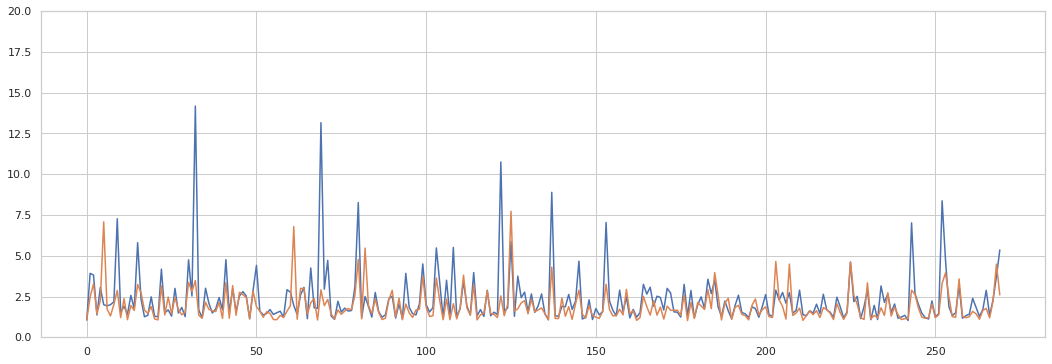

In [ ]:
plt.figure (figsize=(18,6))
plt.plot(dde['cote_1_basée_proba'])
plt.plot(dde['1'])
plt.ylim([0,20]);

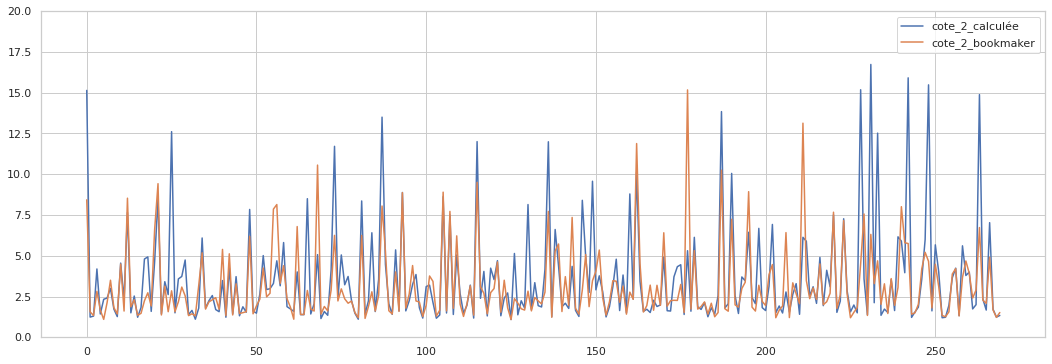

In [ ]:
plt.figure (figsize=(18,6))
plt.plot(dde['cote_2_basée_proba'], label='cote_2_calculée')
plt.plot(dde['2'], label='cote_2_bookmaker')
plt.ylim([0,20])  # cette courbe montre qu'on doit avoir une invserion des cotes V1 et V2
plt.legend();

In [ ]:
# REPRISE DES EXPLOITATIONS DONNEES avec CatBoostClassifier

In [ ]:
x_bis = catb.predict_proba((test_X), 
              ntree_start=0, 
              ntree_end=0, 
              thread_count=-1, 
              verbose=None)

In [ ]:
dfffx=pd.DataFrame.from_dict(x_bis).rename(columns={0 : 'Prob_defaite_home', 1:'Prob_victoire_home' })

In [ ]:
ddex=pd.concat([dfffx, test_X_Eval], axis=1)  #

In [ ]:
ddex.head(5) #(-> structure)

,Prob_defaite_home,Prob_victoire_home,1,2
0,0.066067,0.933933,1.08,8.43
1,0.804545,0.195455,2.47,1.56
2,0.771170,0.228830,3.28,1.34
3,0.238800,0.761200,1.44,2.82
4,0.701387,0.298613,2.25,1.67


In [ ]:
ddex['cote_1_basée_proba'] = np.round((1 / ddex['Prob_victoire_home']),2)

ddex['cote_2_basée_proba'] = np.round((1 / ddex['Prob_defaite_home']),2)

ddex['cote_1_naive_vict_home'] = 1 

ddex['cote_2_naive_vict_away'] = 0 

ddex.head(5) # basé modèle Catboost



,Prob_defaite_home,Prob_victoire_home,1,2,cote_1_basée_proba,cote_2_basée_proba,cote_1_naive_vict_home,cote_2_naive_vict_away
0,0.066067,0.933933,1.08,8.43,1.07,15.14,1,0
1,0.804545,0.195455,2.47,1.56,5.12,1.24,1,0
2,0.771170,0.228830,3.28,1.34,4.37,1.30,1,0
3,0.238800,0.761200,1.44,2.82,1.31,4.19,1,0
4,0.701387,0.298613,2.25,1.67,3.35,1.43,1,0


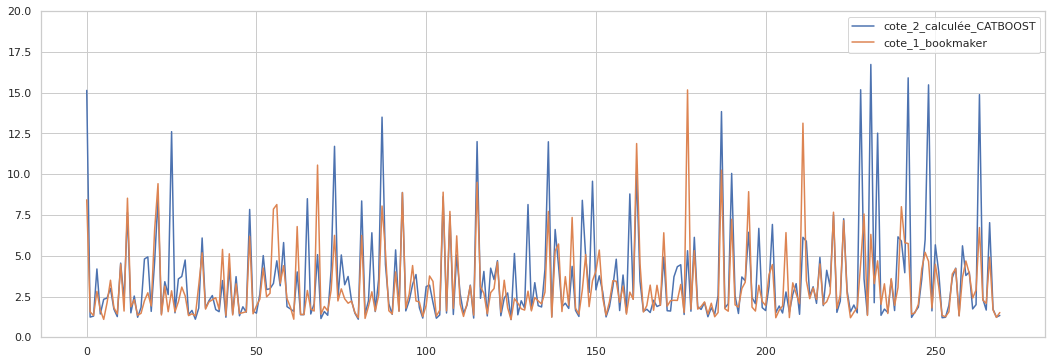

In [ ]:
plt.figure (figsize=(18,6))
plt.plot(ddex['cote_2_basée_proba'], label='cote_2_calculée_CATBOOST')
plt.plot(ddex['2'], label='cote_1_bookmaker')
plt.ylim([0,20])  # cette courbe montre qu'on doit avoir une invserion des cotes V1 et V2
plt.legend();

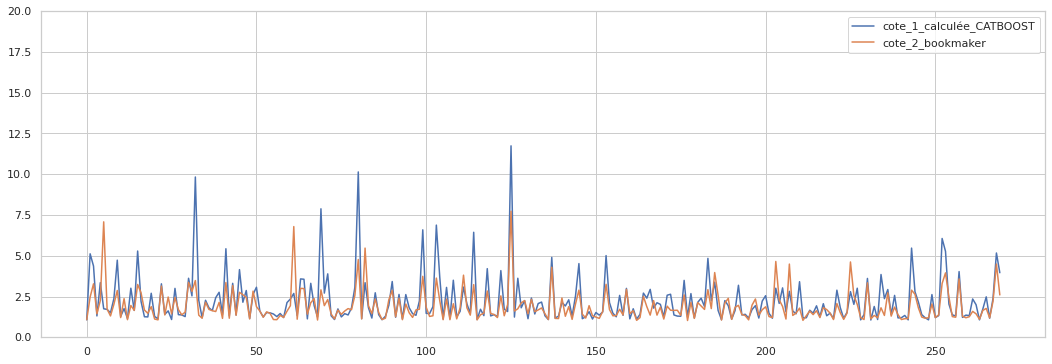

In [ ]:
plt.figure (figsize=(18,6))
plt.plot(ddex['cote_1_basée_proba'], label='cote_1_calculée_CATBOOST')
plt.plot(ddex['1'], label='cote_2_bookmaker')
plt.ylim([0,20])  # cette courbe montre qu'on doit avoir une invserion des cotes V1 et V2
plt.legend();

# suite -> new metrique

In [ ]:
def bankroll(DATA):
  DATA["Bankroll"]=0.00
  if (DATA["Predictions"][0] == DATA["winner_team_id"][0]):
    DATA["Bankroll"][0]=10*float((DATA[DATA["winner_team_id"][0]][0]))-10
  else :
    DATA["Bankroll"][0]=-10.00
  for i in range(1,len(DATA)) :
    if (DATA["Predictions"][i] == DATA["winner_team_id"][i]):
      DATA["Bankroll"][i]=10*float((DATA[DATA["winner_team_id"][i]][i]))-10 + DATA["Bankroll"][i-1]
    else :
      DATA["Bankroll"][i]=DATA["Bankroll"][i-1]-10

def ROI(DATA):
  DATA["ROI"]=0.00
  for i in range(0,len(DATA)) :
      DATA["ROI"][i]=(DATA["Bankroll"][i]/((i+1)*10))*100

def ValueBet(DATA):
  DATA["ValueBet"]=0
  for i in range(0,len(DATA)) :
    if (DATA["PredProbV1"][i]==max(DATA["PredProbV1"][i],DATA["PredProbN"][i],DATA["PredProbV2"][i])):
      if ( ((DATA["PredProbV1"][i]) - 1/(DATA["V1"][i])) > 0 ) :
        DATA["ValueBet"][i]=1
      else:
        DATA["ValueBet"][i]=0
    elif (DATA["PredProbN"][i]==max(DATA["PredProbV1"][i],DATA["PredProbN"][i],DATA["PredProbV2"][i])):
      if ( ((DATA["PredProbN"][i]) - 1/(DATA["N"][i])) > 0 ) :
        DATA["ValueBet"][i]=1
      else:
        DATA["ValueBet"][i]=0
    else:
      if ( ((DATA["PredProbV2"][i]) - 1/(DATA["V2"][i])) > 0 ) :
        DATA["ValueBet"][i]=1
      else:
        DATA["ValueBet"][i]=0

def sucessRate(DATA):
  DATA["SucessRate"]=0.0
  for i in range(0,len(DATA)) :
    if(DATA["Predictions"][i] == DATA["winner_team_id"][i]):
      DATA["SucessRate"][i]=1
    else :
      DATA["SucessRate"][i]=0
      
def ACCU(DATA):
  DATA["Accuracy"]=0.0
  for i in range(0,len(DATA)) :
    if(len(DATA["SucessRate"][0:i+1].value_counts(normalize=True))>1):
      DATA["Accuracy"][i]=DATA["SucessRate"][0:i+1].value_counts(normalize=True)[1]

In [ ]:
# commentaire : 
# bankroll -> mise de 10 unités (euros ou autres)
# ROI = bankroll / somme des mises de 10 unites

# Un « Value Bet » (ou une « Value Bet ») est un pari où le parieur estime que la cote proposée par 
# le bookmaker est supérieure à la cote objective de la rencontre
# ou tout du moins à la cote que le parieur aurait donné pour la rencontre

# Une « Value Bet » correspond toujours à une cote que l'on considère comme erronée, et même comme fortement erronée
# Si on joue tout le temps des « Value Bet », même si on perd certains paris, on sera bénéficiaire au final car les cotes jouées seront supérieures à la moyenne de nos pertes

# DATA['V1'] ou DATA['V2'] ou DATA['N'] = cote du BOOKMAKER
# DATA["PredProbV1"] ou DATA["PredProbV2"] ou DATA["PredProbN"] = calcul de proba V1 ou V2 ou N issu du MODELE DE CALCUL

# ex:  si DATA["PredProbV1"] > 1 / DATA['V1'] -> on est dans le cas d'un valuebet et il faut parier V1